# Обучение с учителем: качество модели

## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Введение

**Исходные данные:**
- данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;
- данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;
- данные о времени (в минутах), которое покупатель провёл на сайте в течение периода;
- данные о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Цель работы:**
Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**План исследования:**
1. Загрузить данные. 
2. Выполнить предобработку данных. 
3. Выполнить исследовательский анализ данных. 
4. Объединить таблицы. 
5. Выполнить корреляционный анализ. 
6. Использовать пайплайны. 
7. Выполнить анализ важности признаков. 

## Загрузка данных

In [118]:
# !pip install -q phik
# !pip install -q imblearn
# !pip install -q shap
# !pip install -q matplotlib==3.5.0

In [119]:
# импортируем все необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)
from sklearn.metrics import (
    confusion_matrix, 
    roc_auc_score, 
    accuracy_score, 
    f1_score, 
    roc_curve,
    make_scorer
)

import shap
from phik import phik_matrix
from phik.report import plot_correlation_matrix
# from imblearn.over_sampling import RandomOverSampler

In [120]:
# введем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

sns.set_style("whitegrid")
pd.set_option('display.max_rows', None)

In [121]:
# открываем файлы с данными 
try:
    market_file = pd.read_csv('datasets/market_file.csv')
    market_money = pd.read_csv('datasets/market_money.csv')
    market_time = pd.read_csv('datasets/market_time.csv')
    money = pd.read_csv('datasets/money.csv', sep=';', decimal = ',')
except:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')

#### market_file

In [122]:
# Выведем на экран 10 строк из набора данных
market_file.head(10)

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   
5  215353                 Снизилась   стандартт                 да   
6  215354                 Снизилась   стандартт                 да   
7  215355                 Снизилась   стандартт                нет   
8  215356                 Снизилась   стандартт                 да   
9  215357                 Снизилась   стандартт                 да   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   
5                 3.3                     4           762               0.26   
6                 5.1                     3           431               0.23   
7                 4.7                     4           284               0.17   
8                 4.2                     4           192               0.14   
9                 3.9                     5           154               0.00   

             Популярная_категория  Средний_просмотр_категорий_за_визит  \
0                Товары для детей                                    6   
1                Товары для детей                                    4   
2               Домашний текстиль                                    5   
3                Товары для детей                                    5   
4                Товары для детей                                    3   
5               Домашний текстиль                                    4   
6           Косметика и аксесуары                                    2   
7                Товары для детей                                    5   
8           Косметика и аксесуары                                    2   
9  Техника для красоты и здоровья                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2  
5                                   1               1                 4  
6                                   3               7                 2  
7                                   1               6                 4  
8                                   2               1                 3  
9                                   3               9                 5

In [123]:
# Выведем основную информацию о датафрейме 
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

#### market_money

In [124]:
# Выведем на экран 10 строк из набора данных
market_money.head(10)

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6
5  215349     предыдущий_месяц   5216.0
6  215350  препредыдущий_месяц   4826.0
7  215350        текущий_месяц   5058.4
8  215350     предыдущий_месяц   5457.5
9  215351        текущий_месяц   6610.4

In [125]:
# Выведем основную информацию о датафрейме 
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


#### market_time

In [126]:
# Выведем на экран 10 строк из набора данных
market_time.head(10)

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13
5  215350  предыдцщий_месяц      8
6  215351     текущий_месяц     13
7  215351  предыдцщий_месяц     11
8  215352     текущий_месяц     11
9  215352  предыдцщий_месяц      8

In [127]:
# Выведем основную информацию о датафрейме 
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


### money

In [128]:
# Выведем на экран 10 строк из набора данных
money.head(10)

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21
5  215353     3.95
6  215354     3.62
7  215355     5.26
8  215356     4.93
9  215357     4.66

In [129]:
# Выведем основную информацию о датафрейме 
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Вывод по результатам загрузки данных

По результатам загрузки данных в рамках их предобработки необходимо выполнить следующее:
- переименовать столбцы;
- проверить наличие пропусков; 
- проверить наличие дубликатов;
- подготовить данные для дальнейшей работы с ними. 

Изменение типов данных в столбцах не требуется. 

## Предобработка данных

### Переименование столбцов

In [130]:
# т.к. по условию задания названия столбцов можно оставить кириллическими, внесем только небольшие изменения

market_file = market_file.rename(columns={'Покупательская активность':'покупательская_активность', 
                              'Тип сервиса':'тип_сервиса', 
                              'Разрешить сообщать':'разрешить_сообщать'
                              })

# приведем названия столбцов к нижнему регистру
market_file.rename(columns=str.lower, inplace=True)

# проверим, что переименование прошло успешно
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [131]:
# приведем названия столбцов к нижнему регистру
market_money.rename(columns=str.lower, inplace=True)

# проверим, что переименование прошло успешно
market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

In [132]:
# приведем названия столбцов к нижнему регистру
market_time.rename(columns=str.lower, inplace=True)

# проверим, что переименование прошло успешно
market_time.columns

Index(['id', 'период', 'минут'], dtype='object')

In [133]:
# приведем названия столбцов к нижнему регистру
money.rename(columns=str.lower, inplace=True)

# проверим, что переименование прошло успешно
money.columns

Index(['id', 'прибыль'], dtype='object')

**Вывод:**

Хоть названия столбцов и остались в кириллице, в них были внесены небольшие изменения, чтобы они соответствовали "правилам хорошего тона".

### Обработка пропусков

In [134]:
# создадим функцию для вывода количества пропусков
def find_omissions(df):
    tmp = df.copy()
    
    missing = (pd.DataFrame({'Количество пропусков': tmp.isnull().sum(), 'Доля пропусков, %': tmp.isnull().mean().round(4)*100})
           .style.background_gradient(cmap='YlOrRd', low=0.5, high=0.3))
    return missing

In [135]:
find_omissions(market_file)

In [136]:
find_omissions(market_money)

In [137]:
find_omissions(market_time)

In [138]:
find_omissions(money)

**Вывод:**

В данных отсутствуют пропуски.

### Поиск дубликатов

In [139]:
# создадим функцию для вывода уникальных значений в столбцах с типом object
def find_duplicate(df):
    for column in df.select_dtypes('object').columns:
        print(column, df[column].unique(), '\n')

In [140]:
find_duplicate(market_file)

покупательская_активность ['Снизилась' 'Прежний уровень'] 

тип_сервиса ['премиум' 'стандартт' 'стандарт'] 

разрешить_сообщать ['да' 'нет'] 

популярная_категория ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника'] 



In [141]:
# уберем неявные дубликаты заменой значений
market_file.loc[market_file['тип_сервиса']=='стандартт', 'тип_сервиса'] = 'стандарт'

market_file.loc[market_file['популярная_категория']=='Косметика и аксесуары', 'популярная_категория'] = 'Косметика и аксессуары'

In [142]:
find_duplicate(market_money)

период ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц'] 



In [143]:
find_duplicate(market_time)

период ['текущий_месяц' 'предыдцщий_месяц'] 



In [144]:
# скорректируем опечатку в данных
market_time.loc[market_time['период']=='предыдцщий_месяц', 'период'] = 'предыдущий_месяц'

In [145]:
# проверим количество явных дубликатов в каждом датафрейме
market_file.duplicated().sum()

np.int64(0)

In [146]:
market_money.duplicated().sum()

np.int64(0)

In [147]:
market_time.duplicated().sum()

np.int64(0)

In [148]:
money.duplicated().sum()

np.int64(0)

**Вывод:**

В данных отсутствуют полные дубликаты строк. 

Неявные дубликаты и опечатки были скорректированы. 

### Подготовка данных

In [149]:
# зададим id в качестве индексов датафреймов, чтобы по ним соединять таблицы в дальнейшем
# market_file = market_file.set_index('id') 
# market_money = market_money.set_index('id') 
# market_time = market_time.set_index('id') 
# money = money.set_index('id') 

# для проверки корректности внесенных изменений выведем первые строки датафрейма
market_file.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась    стандарт                нет   
3  215351                 Снизилась    стандарт                 да   
4  215352                 Снизилась    стандарт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

**Вывод:**

Были заменены индексы датафреймов на значения из полей id каждого датафрейма.

### Вывод по результатам предобработки данных

Качество данных достаточно хорошее. 

Было выполнено: 
- корректировка названий столбцов;
- корректировка значений для исключения неявных дубликатов.

Пропуски и полные дубликаты строк в данных отсутствуют. 

## Исследовательский анализ данных

### Сводные данные

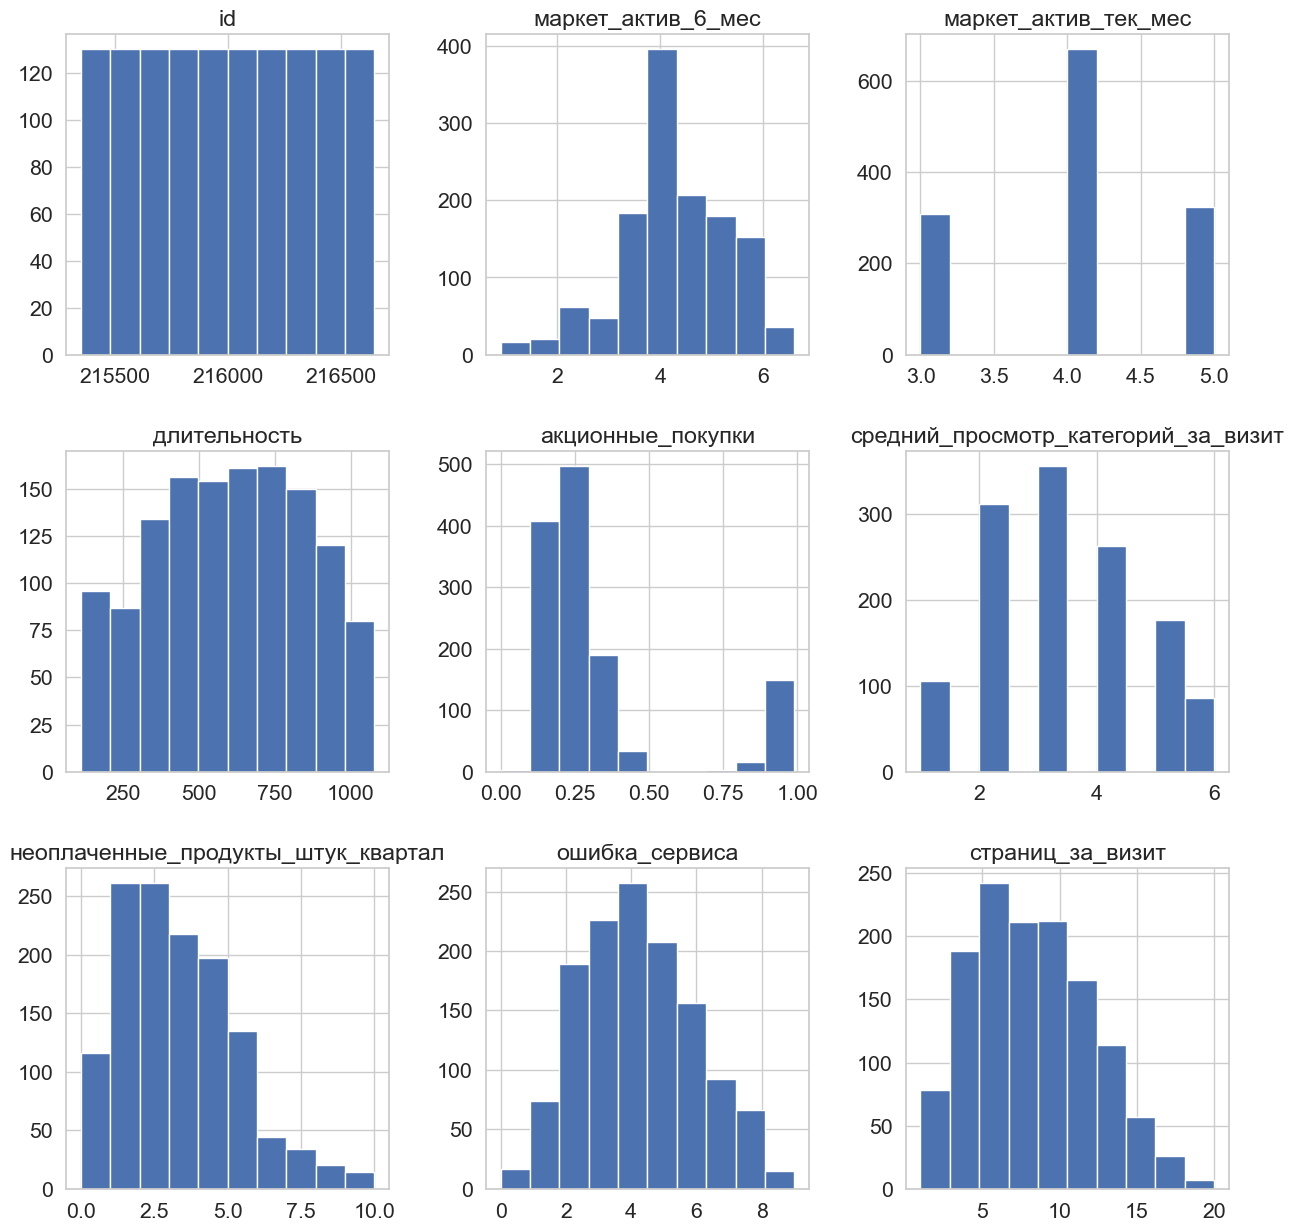

In [150]:
# Построим гистограмму для всех числовых столбцов таблицы на одном графике
market_file.select_dtypes(['int64', 'float']).hist(figsize=(15, 15));

**Вывод:**

По результатам анализа сводных данных можно заметить похожее на нормальное распределение следующих признаков:
- маркет_актив_6_мес;
- длительность;
- средний_просмотр_категорий_за_визит;
- ошибка_сервиса;
- страниц_за_визит.

Но прежде, чем сделать какие-либо выводы, нужно рассмотреть каждый признак детальнее.

### Анализ признаков (market_file)

#### Покупательская активность

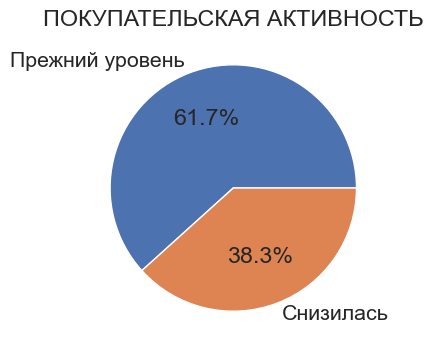

In [151]:
plt.figure(figsize=(4,4))
market_file.value_counts('покупательская_активность').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Покупательская активность'.upper())
plt.xlabel('')
plt.ylabel('');

In [152]:
# заменим строковые значения целевого признака на 0 и 1
market_file.loc[market_file['покупательская_активность'] == 'Снизилась', 'покупательская_активность'] = 1
market_file.loc[market_file['покупательская_активность'] == 'Прежний уровень', 'покупательская_активность'] = 0
market_file['покупательская_активность'] = market_file['покупательская_активность'].astype('int64')

market_file['покупательская_активность'].value_counts()

покупательская_активность
0    802
1    498
Name: count, dtype: int64

Почти у 40% покупателей снизилась покупательская активность.

In [153]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   int64  
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

#### Тип сервиса

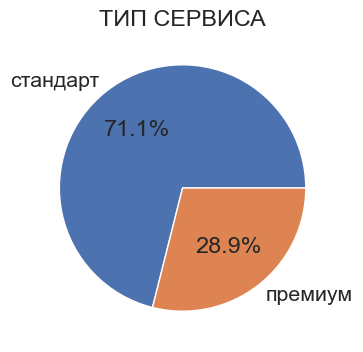

In [154]:
plt.figure(figsize=(4,4))
market_file.value_counts('тип_сервиса').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Тип сервиса'.upper())
plt.xlabel('')
plt.ylabel('');

Большинство покупателей (~70%) пользуются стандартным уровнем сервиса, почти 30% используют премиум. 

#### Разрешить сообщать

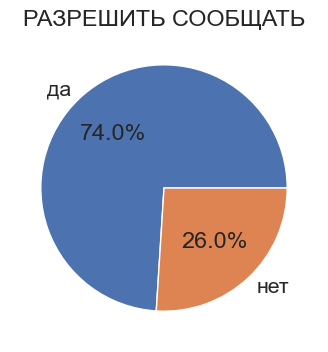

In [155]:
plt.figure(figsize=(4,4))
market_file.value_counts('разрешить_сообщать').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Разрешить сообщать'.upper())
plt.xlabel('')
plt.ylabel('');

Большинство покупателей (74%) дало свое согласие на получение рассылок с дополнительными предложениями о товаре. 

Отказались от рассылок 26%. 

In [156]:
market_file.head()

id  покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                          1     премиум                 да   
1  215349                          1     премиум                 да   
2  215350                          1    стандарт                нет   
3  215351                          1    стандарт                 да   
4  215352                          1    стандарт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

#### Маркет_актив_6_мес

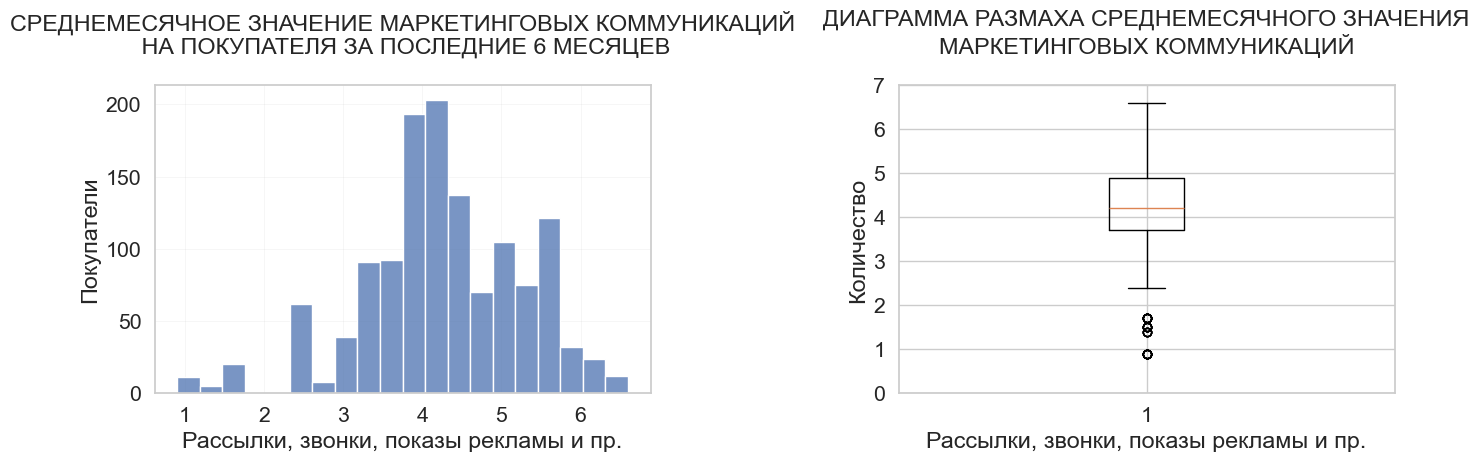

In [157]:
plt.figure(figsize=(16, 4))

# построим гистограмму
plt.subplot(1, 2, 1)
sns.histplot(market_file['маркет_актив_6_мес'], bins=20)
plt.title('Среднемесячное значение маркетинговых коммуникаций\n на покупателя за последние 6 месяцев\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Рассылки, звонки, показы рекламы и пр.')
plt.ylabel('Покупатели');
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 2)
# построим диаграмму размаха
plt.boxplot(market_file['маркет_актив_6_мес'])
plt.title('Диаграмма размаха среднемесячного значения\nмаркетинговых коммуникаций\n'.upper())
plt.grid(visible=True)
plt.ylim(0, 7)
plt.xlabel('Рассылки, звонки, показы рекламы и пр.')
plt.ylabel('Количество');

In [158]:
market_file['маркет_актив_6_мес'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

**Вывод:**

Количество ежемесячных маркетинговых коммуникаций на покупателя за последние 6 месяцев в среднем составляет ~4.2. 

Распределение похоже на нормальное. 

Были выявлены выбросы, было принято решение оставить их как есть.

#### Маркет_актив_тек_мес

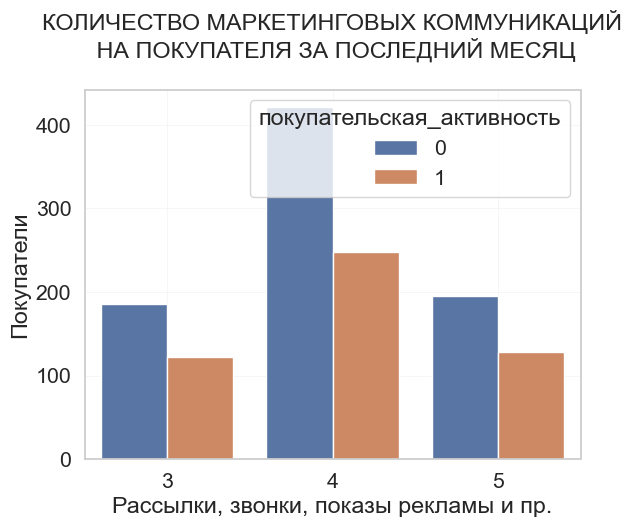

In [159]:
# построим график
sns.countplot(data=market_file, x=market_file['маркет_актив_тек_мес'], hue='покупательская_активность')
plt.title('Количество маркетинговых коммуникаций\n на покупателя за последний месяц\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Рассылки, звонки, показы рекламы и пр.')
plt.ylabel('Покупатели');

In [160]:
market_file['маркет_актив_тек_мес'].value_counts()

маркет_актив_тек_мес
4    669
5    323
3    308
Name: count, dtype: int64

**Вывод:**

Количество маркетинговых коммуникаций на покупателя за последний месяц варьируется в диапазоне от 3 до 5. 

Было принято решение создать еще категориальный признак.

#### Длительность

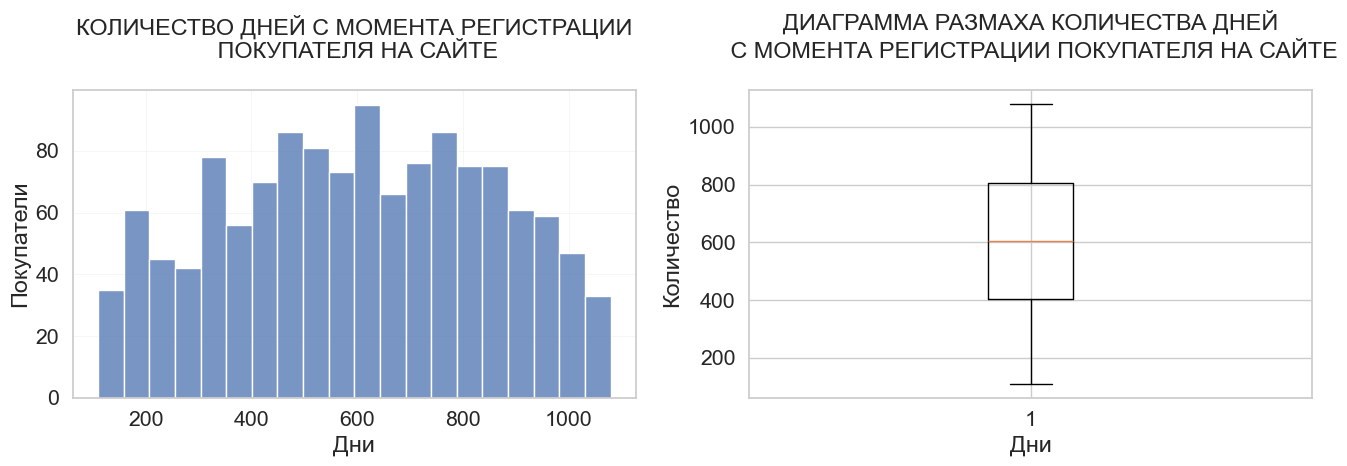

In [161]:
plt.figure(figsize=(16, 4))

# построим гистограмму
plt.subplot(1, 2, 1)
sns.histplot(market_file['длительность'], bins=20)
plt.title('Количество дней с момента регистрации\n покупателя на сайте\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Дни')
plt.ylabel('Покупатели');

# построим диаграмму размаха
plt.subplot(1, 2, 2)
plt.boxplot(market_file['длительность'])
plt.title('Диаграмма размаха количества дней\n с момента регистрации покупателя на сайте\n'.upper())
plt.grid(visible=True)
plt.xlabel('Дни')
plt.ylabel('Количество');


In [162]:
market_file['длительность'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

**Вывод:**

Количество дней с момента регистрации покупателя на сайте в среднем составляет ~600. 

Распределение похоже на нормальное. 

Самый "старый" пользователь сайта был зарегистрирован 1079 дней назад. 

За последние 110 дней на сайте никто не регистрировался. 

Выбросов обнаружено не было. 

#### Акционные покупки

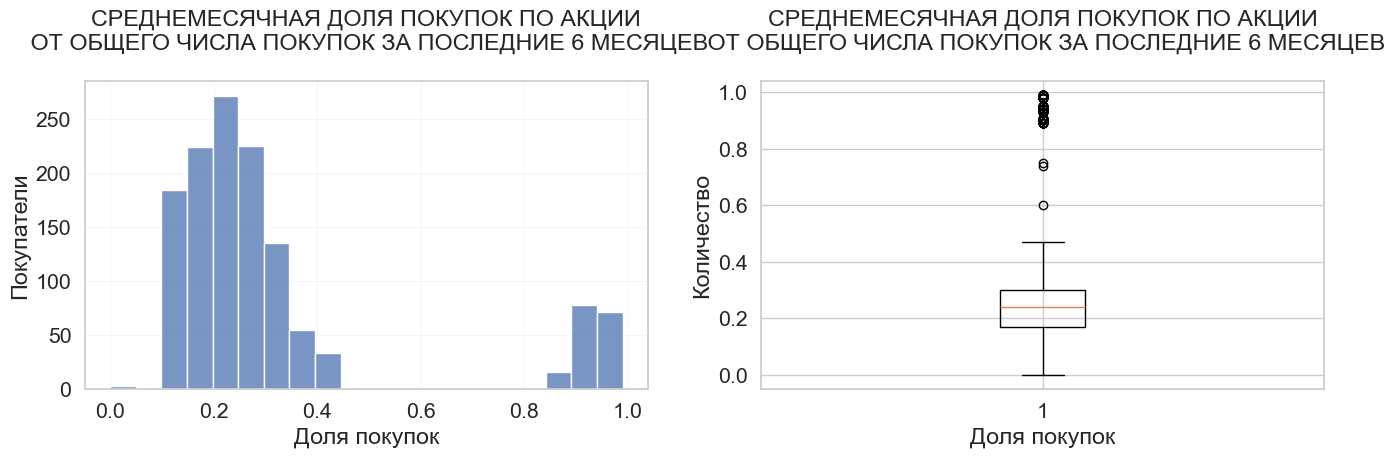

In [163]:
plt.figure(figsize=(16, 4))

# построим гистограмму
plt.subplot(1, 2, 1)
sns.histplot(market_file['акционные_покупки'], bins=20)
plt.title('Среднемесячная доля покупок по акции\n от общего числа покупок за последние 6 месяцев\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Доля покупок')
plt.ylabel('Покупатели');

# построим диаграмму размаха
plt.subplot(1, 2, 2)
plt.boxplot(market_file['акционные_покупки'])
plt.title('Среднемесячная доля покупок по акции\n от общего числа покупок за последние 6 месяцев\n'.upper())
plt.grid(visible=True)
plt.xlabel('Доля покупок')
plt.ylabel('Количество');

In [164]:
market_file['акционные_покупки'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

**Вывод:**

Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев составляет ~ 30%. 

Распределение не похоже на нормальное. 

При этом есть клиенты, которые как покупают товары практически только по акциям (доля покупок 99%), так и те, кто не пользуется акциями никогда. 

#### Популярная категория

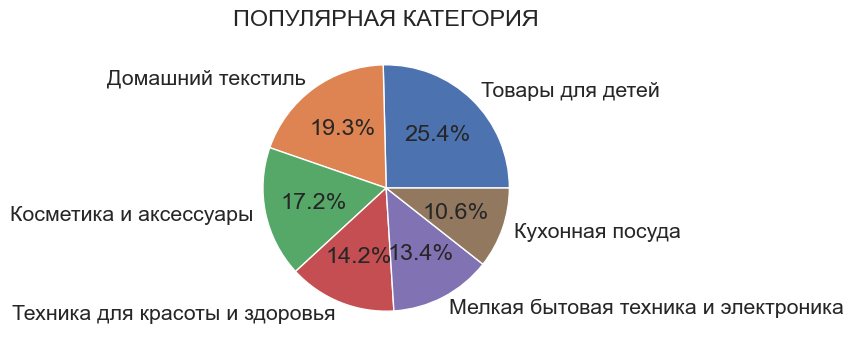

In [165]:
plt.figure(figsize=(4,4))
market_file.value_counts('популярная_категория').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Популярная категория'.upper())
plt.xlabel('')
plt.ylabel('');

**Вывод:** 

Наиболее популярной категорией покупателей являются товары для детей. 

Наименее популярной - кухонная посуда. 

#### Cредний_просмотр_категорий_за_визит

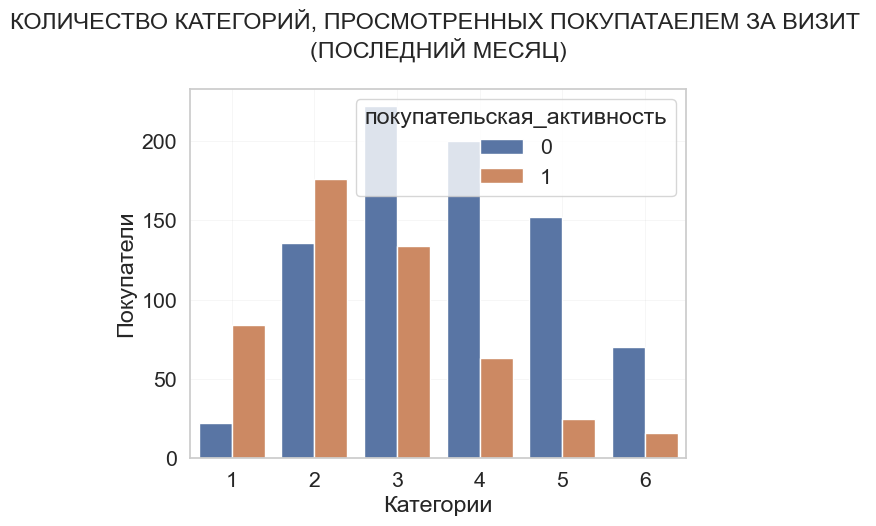

In [166]:
# построим график
sns.countplot(data=market_file, x = market_file['средний_просмотр_категорий_за_визит'], hue='покупательская_активность')
plt.title('Количество категорий, просмотренных покупатаелем за визит \n(последний месяц)\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Категории')
plt.ylabel('Покупатели');

In [167]:
market_file['средний_просмотр_категорий_за_визит'].value_counts()

средний_просмотр_категорий_за_визит
3    356
2    312
4    263
5    177
1    106
6     86
Name: count, dtype: int64

**Вывод:**

Распределение похоже на нормальное. 

В среднем количество просмотренных категорий = 3. 

#### Неоплаченные_продукты_штук_квартал

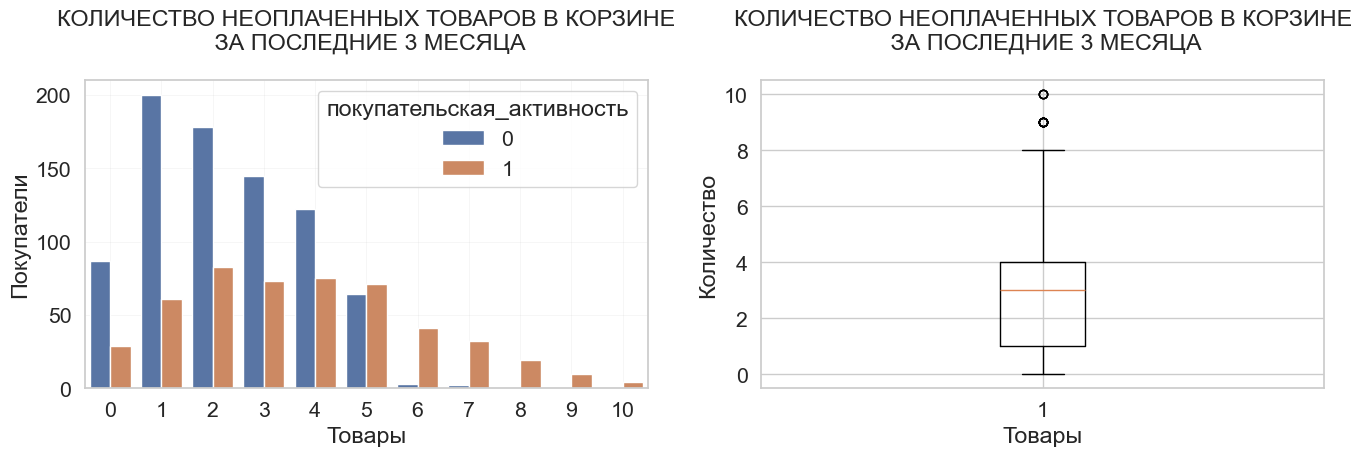

In [168]:
plt.figure(figsize=(16, 4))

# построим график
plt.subplot(1, 2, 1)
sns.countplot(data=market_file, x=market_file['неоплаченные_продукты_штук_квартал'], hue='покупательская_активность')
plt.title('Количество неоплаченных товаров в корзине\n за последние 3 месяца\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Товары')
plt.ylabel('Покупатели');

# построим диаграмму размаха
plt.subplot(1, 2, 2)
plt.boxplot(market_file['неоплаченные_продукты_штук_квартал'])
plt.title('Количество неоплаченных товаров в корзине\n за последние 3 месяца\n'.upper())
plt.grid(visible=True)
plt.xlabel('Товары')
plt.ylabel('Количество');

In [169]:
market_file['неоплаченные_продукты_штук_квартал'].describe()

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

**Вывод:**

Медианное количество неоплаченных товаров в корзине за последние 3 месяца равно 2. 

Распределение не похоже на нормальное. 

Были выявлены выбросы, было принято решение оставить их как есть. ~~и удалены выбросы (количество превышало 8 шт.).~~

#### Ошибка сервиса

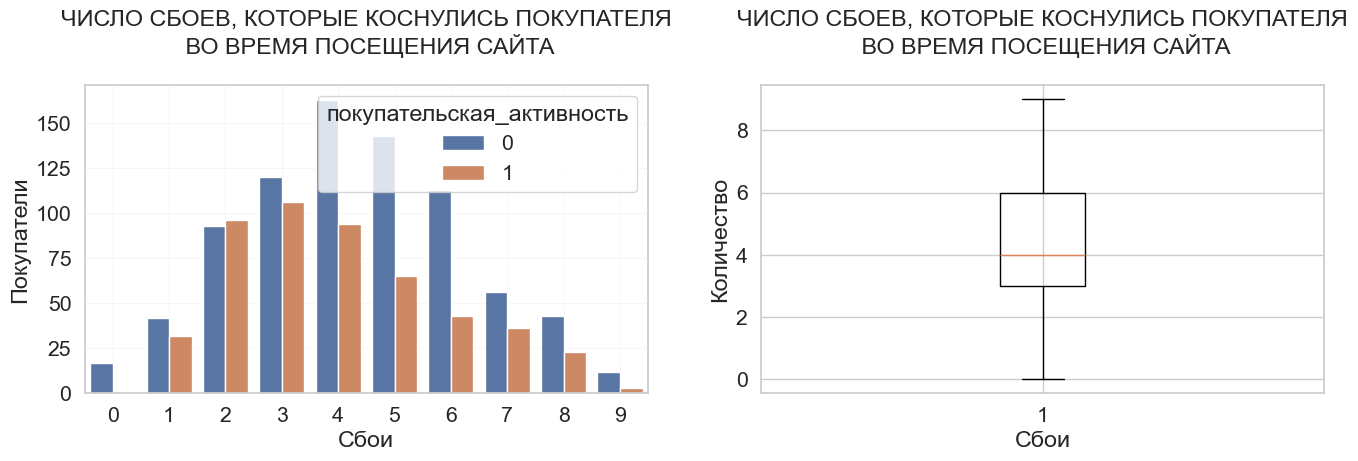

In [170]:
plt.figure(figsize=(16, 4))

# построим график
plt.subplot(1, 2, 1)
sns.countplot(data=market_file, x=market_file['ошибка_сервиса'], hue='покупательская_активность')
plt.title('Число сбоев, которые коснулись покупателя\n во время посещения сайта\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Сбои')
plt.ylabel('Покупатели');

# построим диаграмму размаха
plt.subplot(1, 2, 2)
plt.boxplot(market_file['ошибка_сервиса'])
plt.title('Число сбоев, которые коснулись покупателя\n во время посещения сайта\n'.upper())
plt.grid(visible=True)
plt.xlabel('Сбои')
plt.ylabel('Количество');

In [171]:
market_file['ошибка_сервиса'].describe()

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: ошибка_сервиса, dtype: float64

**Вывод:**

Число сбоев, которые коснулись покупателя во время посещения сайта, в среднем равно 4. 

Выбросы не выявлены. 

#### Страниц за визит

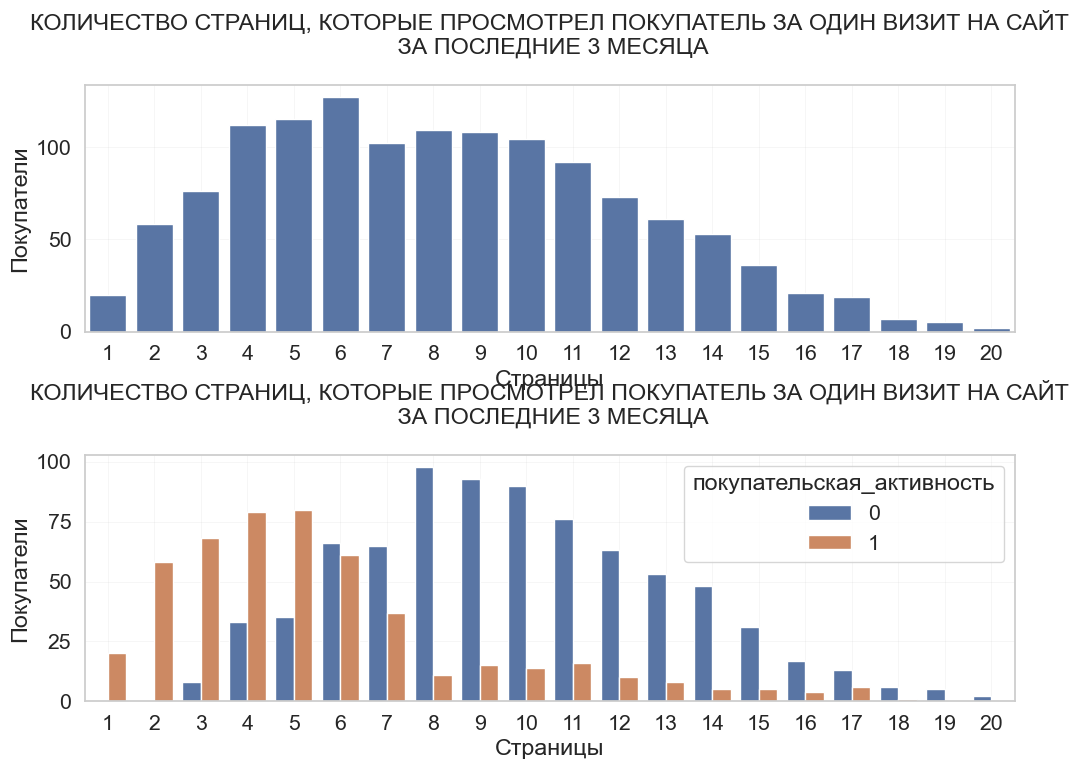

In [172]:
plt.figure(figsize=(12, 8))

# построим график
plt.subplot(2, 1, 1)
plt.subplots_adjust(hspace=0.5)
sns.countplot(data=market_file, x=market_file['страниц_за_визит'])
plt.title('Количество страниц, которые просмотрел покупатель за один визит на сайт\n за последние 3 месяца\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Страницы')
plt.ylabel('Покупатели');

plt.subplot(2, 1, 2)
# построим график с разбивкой по таргету
sns.countplot(data=market_file, x=market_file['страниц_за_визит'], hue='покупательская_активность')
plt.title('Количество страниц, которые просмотрел покупатель за один визит на сайт\n за последние 3 месяца\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Страницы')
plt.ylabel('Покупатели');

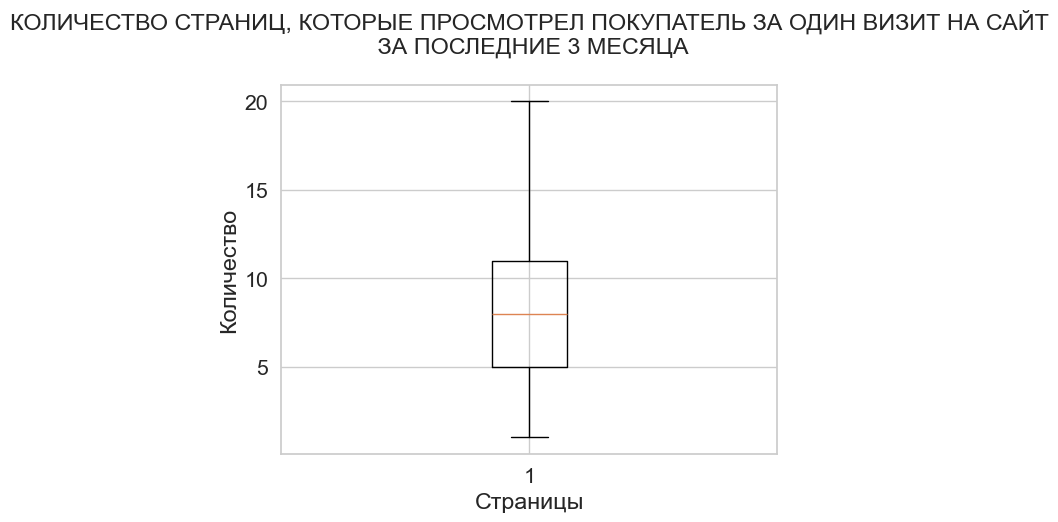

In [173]:
# построим диаграмму размаха
plt.boxplot(market_file['страниц_за_визит'])
plt.title('Количество страниц, которые просмотрел покупатель за один визит на сайт\n за последние 3 месяца\n'.upper())
plt.grid(visible=True)
plt.xlabel('Страницы')
plt.ylabel('Количество');

In [174]:
market_file['страниц_за_визит'].describe()

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: страниц_за_визит, dtype: float64

**Вывод:**

Количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца, в среднем равно 8. 

Выбросы не выявлены. 

### Анализ признаков (market_money)

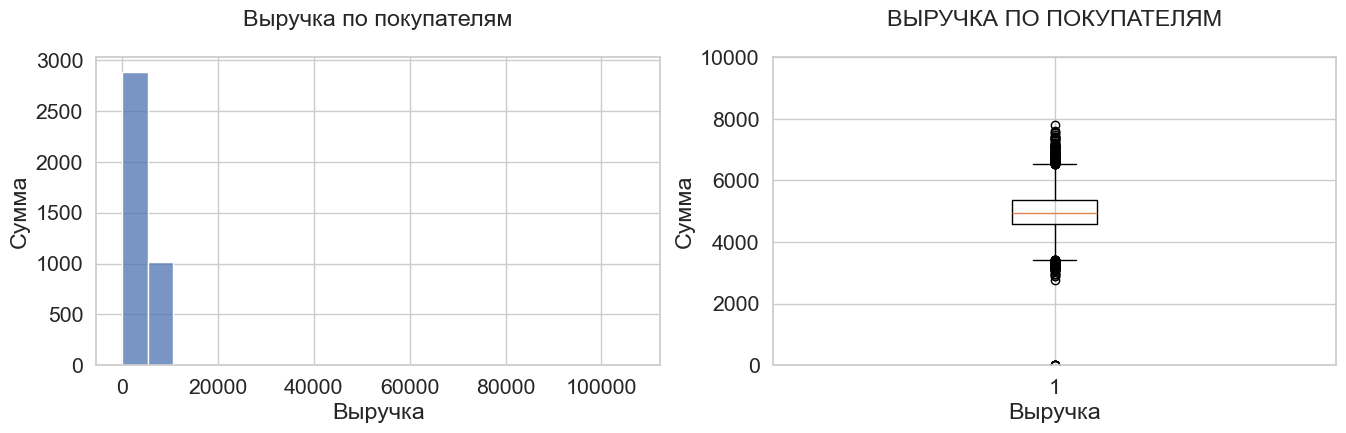

In [175]:
plt.figure(figsize=(16, 4))

# построим гистограмму
plt.subplot(1, 2, 1)
sns.histplot(market_money['выручка'], bins=20, legend='')
plt.title(f'Выручка по покупателям\n')
plt.xlabel('Выручка')
plt.ylabel('Сумма');

# построим диаграмму размаха
plt.subplot(1, 2, 2)
plt.boxplot(market_money['выручка'])
plt.title('Выручка по покупателям\n'.upper())
plt.grid(visible=True)
plt.ylim(0, 10000)
plt.xlabel('Выручка')
plt.ylabel('Сумма');

In [176]:
# удалим выброс
market_money = market_money[market_money['выручка'] <= 10000]

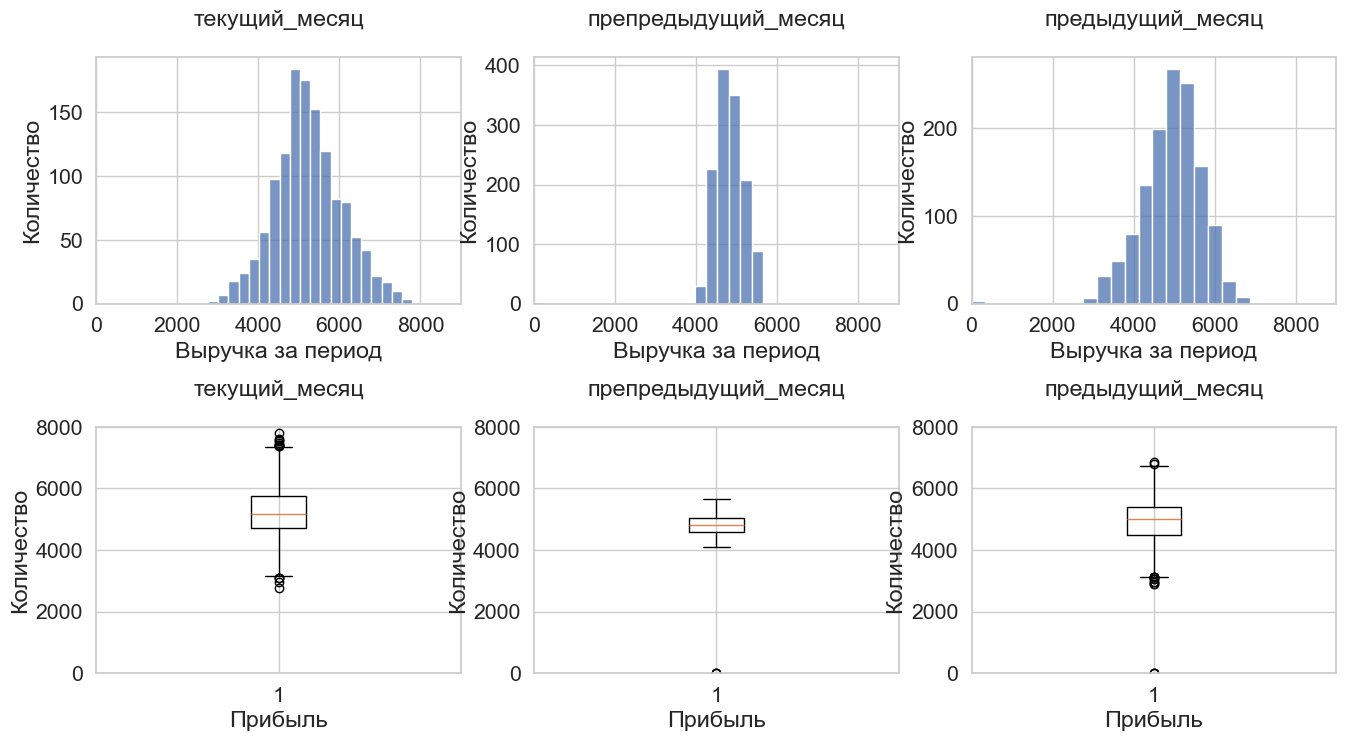

In [177]:
periods = market_money['период'].sort_values(ascending=False).unique()

plt.figure(figsize=(16, 8))
i = 1
for period in periods:
    # гистограмма
    df_1 = market_money[market_money['период']==period]
    plt.subplot(2, 3, i)
    sns.histplot(data=df_1, x='выручка', bins=20, legend='')
    plt.title(f'{period}\n')
    plt.xlim(0, 9000)
    plt.xlabel('Выручка за период')
    plt.ylabel('Количество')
    plt.subplots_adjust(hspace=0.5)

    # диаграмма размаха
    df_2 = market_money[market_money['период']==period]['выручка']
    plt.subplot(2, 3, i+3)
    plt.boxplot(df_2)
    plt.title(f'{period}\n')
    plt.grid(visible=True)
    plt.xlabel('Прибыль')
    plt.ylabel('Количество')
    plt.ylim(0, 8000)
    i+=1;

In [ ]:
df = pd.DataFrame()
# построим описание данных
for period in periods:
    df[period] = market_money[market_money['период']==period]['выручка'].describe()
df

текущий_месяц  препредыдущий_месяц  предыдущий_месяц
count    1299.000000          1300.000000       1300.000000
mean     5236.787452          4825.206923       4936.920385
std       835.474686           405.979663        739.597997
min      2758.700000             0.000000          0.000000
25%      4705.500000          4583.000000       4496.750000
50%      5179.600000          4809.000000       5005.000000
75%      5759.950000          5053.500000       5405.625000
max      7799.400000          5663.000000       6869.500000

**Вывод:**

Среднее и медианное значение выручки в текущем месяце выше, чем в двух других периодах. 

Распределение в каждом периоде похоже на нормальное. 

В текущем месяце явно присутствовала ошибка в данных (максимальное значение выручки = 106862). Удалили выброс.

### Анализ признаков (market_time)

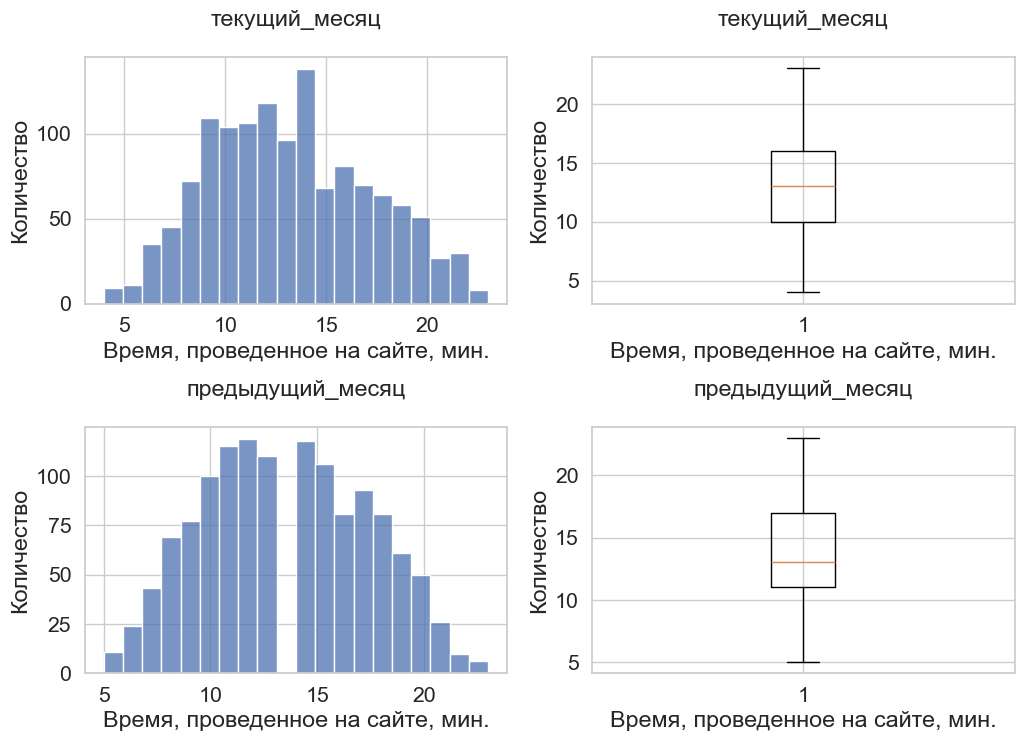

In [179]:
periods = market_time['период'].sort_values(ascending=False).unique()

plt.figure(figsize=(12, 8))
i = 1
for period in periods:
    # гистограмма
    df_1 = market_time[market_time['период']==period]
    plt.subplot(2, 2, i)
    sns.histplot(data=df_1, x='минут', bins=20, legend='')
    plt.title(f'{period}\n')
    plt.xlabel('Время, проведенное на сайте, мин.')
    plt.ylabel('Количество')
    # i += 1;
    plt.subplots_adjust(hspace=0.5)
    
    # диаграмма размаха
    df_2 = market_time[market_time['период']==period]['минут']
    plt.subplot(2, 2, i+1)
    plt.boxplot(df_2)
    plt.title(f'{period}\n')
    plt.grid(visible=True)
    plt.xlabel('Время, проведенное на сайте, мин.')
    plt.ylabel('Количество')
    # plt.ylim(0, 7000)
    i+=2;

**Вывод:**

Время, проведенное на сайте, не сильно меняется в зависимости от периода. 

Распределение похоже на нормальное. 

Медианное значение близко к 12.5 мин. 

Выбросы не обнаружены. 

### Анализ признаков (money)

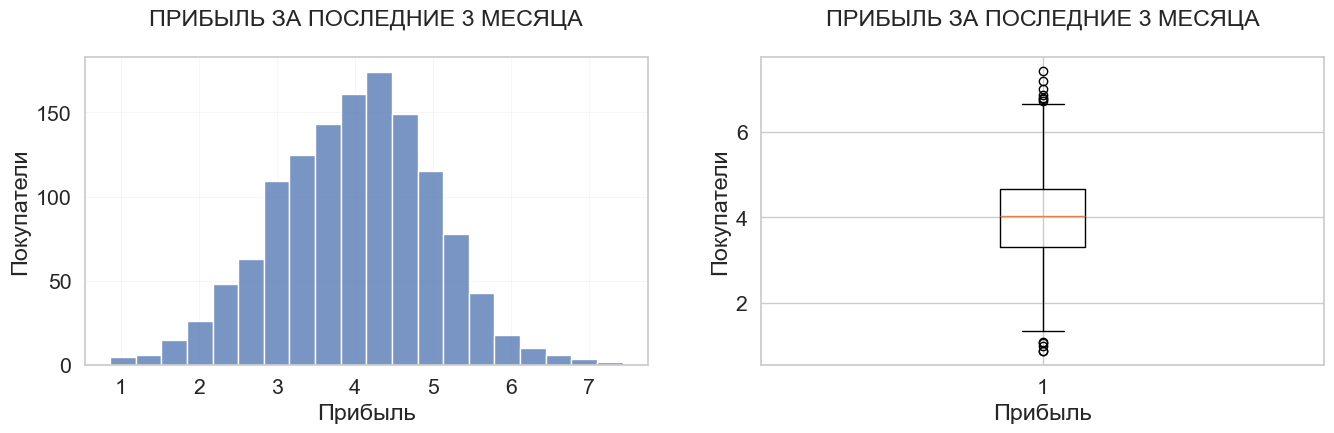

In [180]:
plt.figure(figsize=(16, 4))

# построим гистограмму
plt.subplot(1, 2, 1)
sns.histplot(money['прибыль'], bins=20)
plt.title('Прибыль за последние 3 месяца\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Прибыль')
plt.ylabel('Покупатели');

# построим диаграмму размаха
plt.subplot(1, 2, 2)
plt.boxplot(money['прибыль'])
plt.title('Прибыль за последние 3 месяца\n'.upper())
plt.grid(visible=True)
plt.xlabel('Прибыль')
plt.ylabel('Покупатели');

In [181]:
money['прибыль'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

**Вывод:**

Медианное значение прибыли за последние 3 месяца близко к 4. 

Распределение похоже на нормальное. 

Были выявлены выбросы, было принято решение оставить их как есть. 

### Отбор клиентов с покупательской активностью не менее 3 месяцев

In [182]:
# удаляем строки, в которых выручка равна 0
market_money_dropped = market_money[market_money['выручка'] > 0]

# считаем количество периодов активности для каждого клиента
grouped = market_money_dropped.groupby('id')['период'].size().reset_index(name='активность')

# добавляем периоды активности к market_money
market_money_active = market_money.merge(grouped, on=['id'], how='left')

# фильтруем только те строки, в которых активность равна 3 месяцам, оставляем нужные столбцы
market_money_active = market_money_active[market_money_active['активность'] == 3][['id', 'период', 'выручка']]

# проверяем результат
print(market_money_active.shape)
market_money_active.head(6)

(3888, 3)


id               период  выручка
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6
5  215349     предыдущий_месяц   5216.0
6  215350  препредыдущий_месяц   4826.0
7  215350        текущий_месяц   5058.4
8  215350     предыдущий_месяц   5457.5

**Вывод:**

Были выявлены покупатели, чья покупательская активность составляла менее 3 месяцев подряд. Такие клиенты были удалены из таблицы. 

### Вывод по результатам исследовательского анализа данных

Были проанализированы признаки во всех таблицах. 

На текущий период покупательская активность снизилась у 38.3% клиентов. 

Были удалены выбросы в столбце "выручка".

Были выявлены покупатели, чья покупательская активность составляла менее 3 месяцев подряд. 

Учет таких клиентов мог бы негативно повлиять на модель, поэтому идентификаторы таких клиентов были удалены из выборки. 

## Объединение таблиц

In [183]:
# выполним подготовку таблиц для объединения
market_time = market_time.pivot_table(index='id', columns='период',  values='минут', aggfunc='sum', fill_value=0)

market_time.rename(columns={
    'предыдущий_месяц': 'минут_предыдущий_месяц',
    'текущий_месяц': 'минут_текущий_месяц'
}, inplace=True)

# проверим результат
market_time.head()

период  минут_предыдущий_месяц  минут_текущий_месяц
id                                                 
215348                      13                   14
215349                      12                   10
215350                       8                   13
215351                      11                   13
215352                       8                   11

In [184]:
# выполним подготовку таблиц для объединения
market_money_active = market_money_active.pivot_table(index='id', columns='период',  values='выручка', aggfunc='sum', fill_value=0)

market_money_active.rename(columns={
    'предыдущий_месяц': 'выручка_предыдущий_месяц',
    'текущий_месяц': 'выручка_текущий_месяц',
    'препредыдущий_месяц': 'выручка_препредыдущий_месяц'
}, inplace=True)

# проверим результат
market_money_active.head()

период  выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
215349                    5216.0                       4472.0   
215350                    5457.5                       4826.0   
215351                    6158.0                       4793.0   
215352                    5807.5                       4594.0   
215353                    4738.5                       5124.0   

период  выручка_текущий_месяц  
id                             
215349                 4971.6  
215350                 5058.4  
215351                 6610.4  
215352                 5872.5  
215353                 5388.5

In [185]:
# соединим таблицы
df = market_money_active.merge(market_file, on='id')
df_full = df.merge(market_time, on='id')
df_full = df_full.set_index('id').reset_index(drop=False).set_index('id')

# выведем размер таблицы
print(df_full.shape)

# проверим корректность объединения
df_full.isna().sum()

(1296, 17)


выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

In [186]:
# выведем таблицу на экран
df_full.head()

выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
215349                    5216.0                       4472.0   
215350                    5457.5                       4826.0   
215351                    6158.0                       4793.0   
215352                    5807.5                       4594.0   
215353                    4738.5                       5124.0   

        выручка_текущий_месяц  покупательская_активность тип_сервиса  \
id                                                                     
215349                 4971.6                          1     премиум   
215350                 5058.4                          1    стандарт   
215351                 6610.4                          1    стандарт   
215352                 5872.5                          1    стандарт   
215353                 5388.5                          1    стандарт   

       разрешить_сообщать  маркет_актив_6_мес  маркет_актив_тек_мес  \
id                                                                    
215349                 да                 4.4                     4   
215350                нет                 4.9                     3   
215351                 да                 3.2                     5   
215352                нет                 5.1                     3   
215353                 да                 3.3                     4   

        длительность  акционные_покупки популярная_категория  \
id                                                             
215349           819               0.75     Товары для детей   
215350           539               0.14    Домашний текстиль   
215351           896               0.99     Товары для детей   
215352          1064               0.94     Товары для детей   
215353           762               0.26    Домашний текстиль   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        минут_предыдущий_месяц  минут_текущий_месяц  
id                                                   
215349                      12                   10  
215350                       8                   13  
215351                      11                   13  
215352                       8                   11  
215353                      10                   10

### Вывод по результатам объединения таблиц

В результате объединения таблиц получились пропуски в более чем 30% строк в столбце "минут". 

Было принято решение заменить эти значения медианными. 

На этапе корреляционного анализа нужно будет обратить на этот признак особое внимание. 

## Корреляционный анализ

### Коэффициенты корреляции

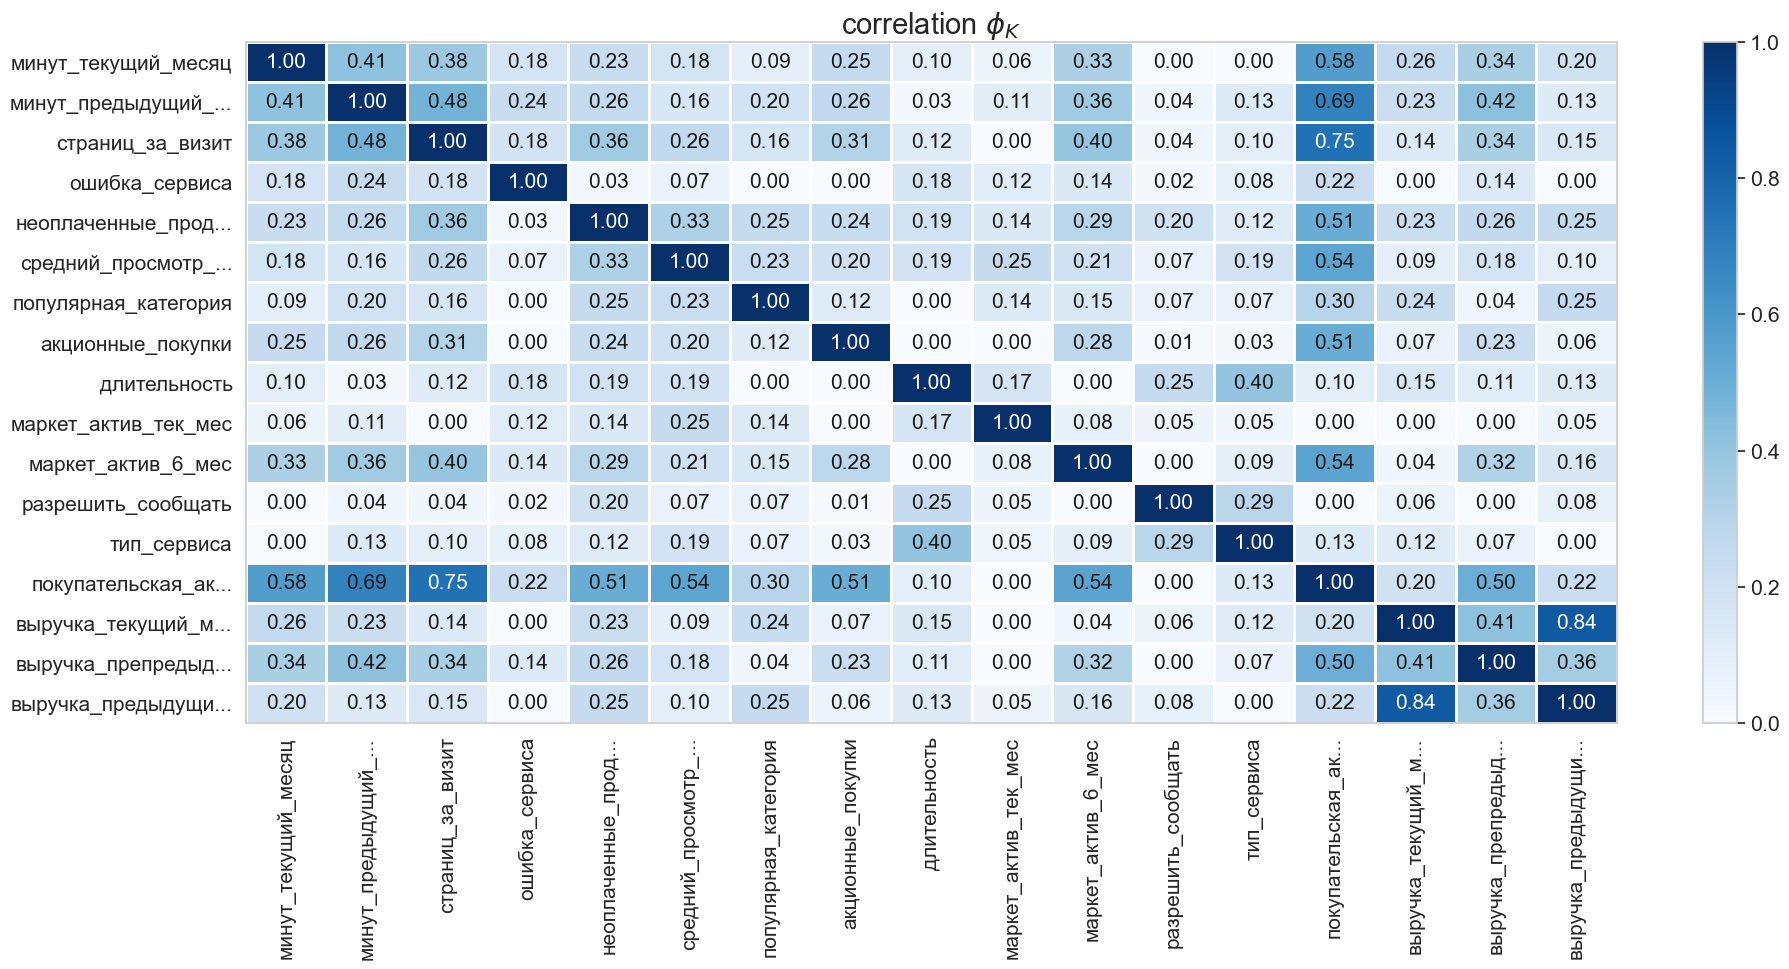

In [187]:
interval_cols = ['выручка_предыдущий_месяц',
                 'выручка_препредыдущий_месяц',
                 'выручка_текущий_месяц',
                 'маркет_актив_6_мес', 
                 'длительность', 
                 'акционные_покупки', 
                 'средний_просмотр_категорий_за_визит',
                 'неоплаченные_продукты_штук_квартал',
                 'страниц_за_визит',
                 'минут_предыдущий_месяц',
                 'минут_текущий_месяц', 
                 ]

phik_overview = phik_matrix(df_full, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 10)
);

### Проверка на мультиколлинеарность

In [188]:
num_cols = ['выручка_предыдущий_месяц',
                 'выручка_препредыдущий_месяц',
                 'выручка_текущий_месяц',
                 'маркет_актив_6_мес', 
                 'маркет_актив_тек_мес',
                 'длительность', 
                 'акционные_покупки', 
                 'средний_просмотр_категорий_за_визит',
                 'неоплаченные_продукты_штук_квартал',
                 'страниц_за_визит',
                 'минут_предыдущий_месяц',
                 'минут_текущий_месяц', 
                 'покупательская_активность'
                 ]

# выполним проверку на мультиколлинеарность с использованием VIF
X = add_constant(df_full[num_cols].drop('покупательская_активность', axis=1))

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data.sort_values(by='VIF', ascending=False)

feature         VIF
0                                 const  352.489397
1              выручка_предыдущий_месяц    4.262817
3                 выручка_текущий_месяц    3.893236
2           выручка_препредыдущий_месяц    1.612073
11               минут_предыдущий_месяц    1.477343
10                     страниц_за_визит    1.417952
12                  минут_текущий_месяц    1.321136
4                    маркет_актив_6_мес    1.219665
9    неоплаченные_продукты_штук_квартал    1.194622
7                     акционные_покупки    1.184042
8   средний_просмотр_категорий_за_визит    1.178342
6                          длительность    1.077002
5                  маркет_актив_тек_мес    1.031135

### Анализ признаков

Выявлена высокая корреляция (0.84) между признаками "выручка_текущий_месяц" и "выручка_предыдущий_месяц".

Посмотрим на корреляцию между выручкой в текущем и предыдущем месяцах.

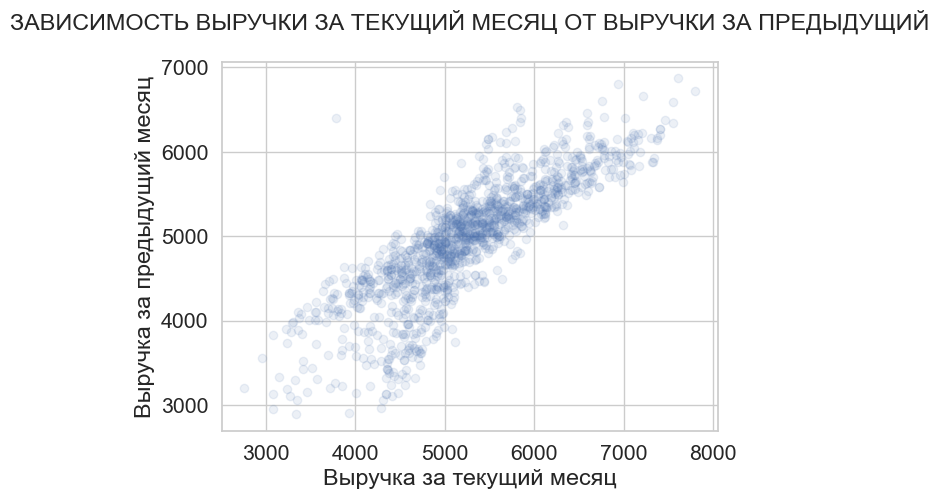

In [189]:
# посмотрим на корреляцию между выручкой в текущем и предыдущем месяцах
plt.scatter(x=df_full['выручка_текущий_месяц'], y=df_full['выручка_предыдущий_месяц'], alpha=0.1)
plt.title(f'Зависимость выручки за текущий месяц от выручки за предыдущий\n'.upper())
plt.xlabel(f'Выручка за текущий месяц')
plt.ylabel('Выручка за предыдущий месяц');

In [190]:
# найдем разницу между выручками за разные месяцы
df_for_corr = df_full.copy()
df_for_corr['препредыдущий_месяц_минус_предыдущий'] = df_full['выручка_препредыдущий_месяц'] - df_full['выручка_предыдущий_месяц']
df_for_corr['предыдущий_месяц_минус_текущий'] = df_full['выручка_предыдущий_месяц'] - df_full['выручка_текущий_месяц']

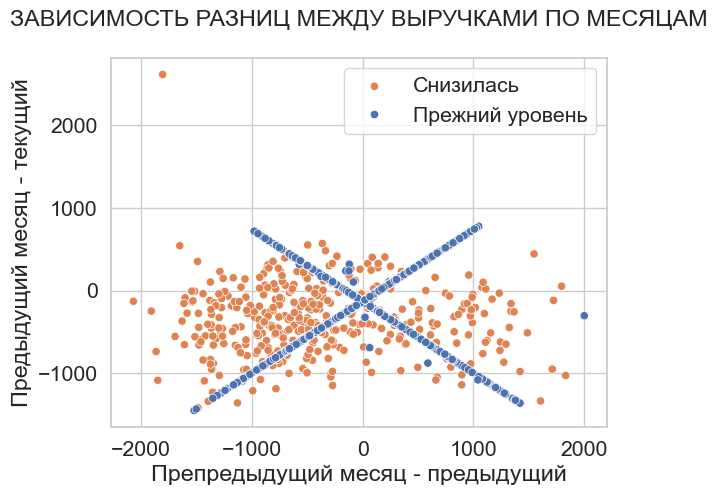

In [191]:
# построим диаграмму зависимостей между разницами
sns.scatterplot(data=df_for_corr, x='препредыдущий_месяц_минус_предыдущий', y='предыдущий_месяц_минус_текущий', hue='покупательская_активность');
plt.title(f'Зависимость разниц между выручками по месяцам\n'.upper())
plt.legend(labels=['Снизилась', 'Прежний уровень'])
plt.xlabel(f'Препредыдущий месяц - предыдущий')
plt.ylabel('Предыдущий месяц - текущий');

На графике видно, что для клиентов с прежним уровнем покупательской активности, характерно линейное увеличение или уменьшение отношения к выручке. 

Разброс разницы выручки от клиентов, у которых покупательская активность снизилась, не линейный, больше сконцентрирован в левом нижнем углу (их расходы от месяца к месяцу в основном уменьшаются). 

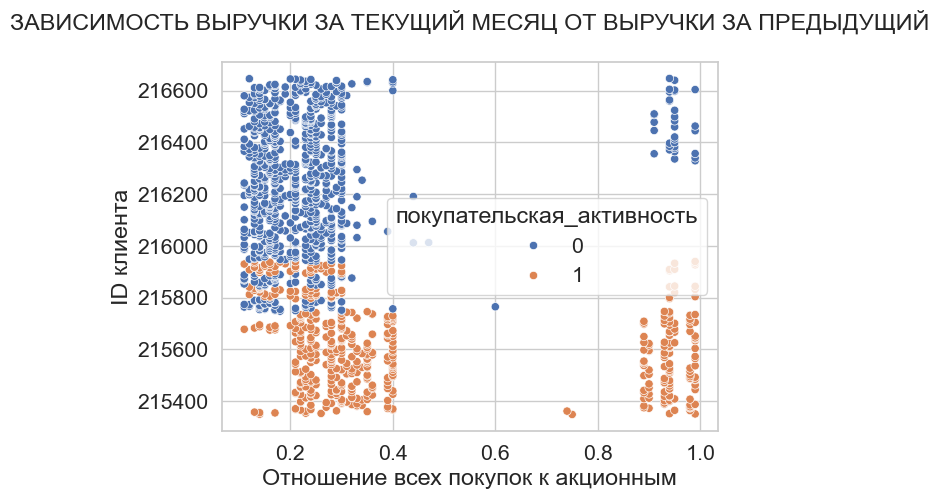

In [192]:
# посмотрим на корреляцию между акционными покупками, покупательской активностью и клиентами
sns.scatterplot(data=df_full, x='акционные_покупки', y='id', hue='покупательская_активность');
plt.title(f'Зависимость выручки за текущий месяц от выручки за предыдущий\n'.upper())
plt.xlabel(f'Отношение всех покупок к акционным')
plt.ylabel('ID клиента');

Из графика можно сделать вывод, что всех клиентов можно разделить на две категории: 
- те, кто практически не покупает товары по акции;
- те, кто большую часть товаров покупают по акции.

При этом покупательская активность снизилась у клиентов, которые раньше других были зарегистрированы в Интернет-магазине. 

Довольно сильно снизилось число покупателей, которые приобретали продукцию в основном по акции, а количество тех, кого акции не интересовали, остались в большинстве. 

Возможно в последнее время снизилось количество акций, либо проводимые акции не удовлетворяют потребности клиентов. Либо покупатели закупились по акциям всем необходимым и пока приобретение товаров им не требуется.

Довольно странно выглядит то, что у клиентов с id от 216 000 до 216 300 полностью покупки по акциям. 

**Вывод:**

В результате анализа графиков можно сделать вывод, что анализируемый dataset синтетический (зависимость покупательской активности от индекса клиентов, 100%-ое отсутствие покупок по акциям для списка клиентов). 

### Вывод по результатам корреляционного анализа

<!-- 1. Выявлен высокий уровень корреляции (0.72) между признаками "страниц_за_визит" и "покупательская_активность". Можно предположить, что чем больше страниц клиент открывает, тем больше товаров приобретает. 
2. Умеренный уровень корреляции (0.53) выявлен между признаками "Cредний_просмотр_категорий_за_визит" и "покупательская_активность".
3. Умеренный уровень корреляции (0.49) выявлен между признаками "маркет_актив_6_мес" и "покупательская_активность". 

Также высокая корреляция (0.71) между периодами (текущим, предыдущим и т.п.). 

Мультиколлинеарность между признаками отсутствует, значит можно брать данные в работу.  -->

1. Выявлен высокий уровень корреляции (0.75) между признаками "страниц_за_визит" и "покупательская_активность". Можно предположить, что чем больше страниц клиент открывает, тем больше товаров приобретает. 
2. Выявлен высокий уровень корреляции (0.69) между признаками "минут_предыдущий_месяц" и "покупательская_активность".
3. Умеренный уровень корреляции (0.54) выявлен между признаками "Cредний_просмотр_категорий_за_визит" и "покупательская_активность".
4. Умеренный уровень корреляции (0.54) выявлен между признаками "маркет_актив_6_мес" и "покупательская_активность". 

Коэффициент инфляции дисперсии (VIF) ни для одного признака не превышает 5, что подтверждает отсутствие мультиколлинеарности.

## Использование пайплайнов

### Пайплайн

In [193]:
# делим данные на входные и целевые
X = df_full.drop(['покупательская_активность'], axis=1)
y = df_full['покупательская_активность']


# создадим тренировочную и тестовую выборки используя стратификацию
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

In [194]:
# для сэмплирования данных посчитаем веса
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)

In [195]:
# разделим признаки на группы
ohe_columns = [
    'разрешить_сообщать',
    'популярная_категория'
]

ord_columns = [
    'тип_сервиса'
]

num_columns = [
    'выручка_предыдущий_месяц',
    'выручка_препредыдущий_месяц', 
    'выручка_текущий_месяц',
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес',
    'длительность', 
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 
    'страниц_за_визит'
]

In [196]:
# SimpleImputer + OHE
try:
    ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ohe', 
                OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
            )
        ]
    )
except:
    ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

ohe_pipe

Pipeline(steps=[('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
                ('ohe',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))])

In [197]:
# SimpleImputer + ORD
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

ord_pipe

Pipeline(steps=[('simpleImputer_before_ord',
                 SimpleImputer(strategy='most_frequent')),
                ('ord',
                 OrdinalEncoder(categories=[['стандарт', 'премиум']],
                                handle_unknown='use_encoded_value',
                                unknown_value=nan)),
                ('simpleImputer_after_ord',
                 SimpleImputer(strategy='most_frequent'))])

In [198]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False
)

data_preprocessor

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['разрешить_сообщать',
                                  'популярная_категория']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord...
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['тип_сервиса']),
                                ('num', StandardScaler(),
                                 ['выручка_предыдущий_месяц',
                                  'выручка_препредыдущий_месяц',
                                  'выручка_текущий_месяц', 'маркет_актив_6_мес',
                                  'маркет_актив_тек_мес', 'длительность',
                                  'акционные_покупки',
                                  'средний_просмотр_категорий_за_визит',
                                  'неоплаченные_продукты_штук_квартал',
                                  'ошибка_сервиса', 'страниц_за_визит'])])

In [199]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        # ('sampler', sampler),
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(s...
                                                 ('num', StandardScaler(),
                                                  ['выручка_предыдущий_месяц',
                                                   'выручка_препредыдущий_месяц',
                                                   'выручка_текущий_месяц',
                                                   'маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит'])])),
                ('models', DecisionTreeClassifier(random_state=42))])

In [200]:
param_grid = [
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1',
            class_weight=dict(enumerate(class_weights))
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(
            random_state=RANDOM_STATE,
            class_weight=dict(enumerate(class_weights))
            )],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },    
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            kernel='poly',
            random_state=RANDOM_STATE,
            probability=True,
            class_weight=dict(enumerate(class_weights))
        )],
        'models__degree': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [201]:
%%time

scoring = {"AUC":'roc_auc', "Accuracy": make_scorer(accuracy_score)}

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scoring,
    # scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1, 
    refit='AUC', 
    verbose=3
)
randomized_search.fit(X_train, y_train)

model = randomized_search.best_estimator_

print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
print('Лучшая модель и её параметры:\n\n')
randomized_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Метрика лучшей модели на тренировочной выборке: 0.8959871317598591
Лучшая модель и её параметры:


CPU times: total: 78.1 ms
Wall time: 234 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(s...
                                                   'маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит'])])),
                ('models',
                 LogisticRegression(C=9,
                                    class_weight={0: np.float64(0.8079800498753117),
                                                  1: np.float64(1.311740890688259)},
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [202]:
# посмотрим на результаты randomized_search
result = pd.DataFrame(randomized_search.cv_results_)
result[['mean_fit_time', 'param_models', 'mean_test_AUC','params', 'rank_test_AUC']].sort_values('rank_test_AUC')

mean_fit_time                                       param_models  \
4       0.023180  LogisticRegression(class_weight={0: np.float64...   
8       0.015229  LogisticRegression(class_weight={0: np.float64...   
9       0.014115  LogisticRegression(class_weight={0: np.float64...   
3       0.070380  SVC(class_weight={0: np.float64(0.807980049875...   
7       0.012275                             KNeighborsClassifier()   
0       0.011027  DecisionTreeClassifier(class_weight={0: np.flo...   
6       0.011560  DecisionTreeClassifier(class_weight={0: np.flo...   
2       0.012115  DecisionTreeClassifier(class_weight={0: np.flo...   
5       0.009880  DecisionTreeClassifier(class_weight={0: np.flo...   
1       0.011727  DecisionTreeClassifier(class_weight={0: np.flo...   

   mean_test_AUC                                             params  \
4       0.895987  {'preprocessor__num': MinMaxScaler(), 'models_...   
8       0.895787  {'preprocessor__num': StandardScaler(), 'model...   
9       0.895651  {'preprocessor__num': RobustScaler(), 'models_...   
3       0.875922  {'preprocessor__num': RobustScaler(), 'models_...   
7       0.868748  {'preprocessor__num': RobustScaler(), 'models_...   
0       0.825538  {'preprocessor__num': StandardScaler(), 'model...   
6       0.807658  {'preprocessor__num': MinMaxScaler(), 'models_...   
2       0.799827  {'preprocessor__num': MinMaxScaler(), 'models_...   
5       0.790170  {'preprocessor__num': 'passthrough', 'models__...   
1       0.790170  {'preprocessor__num': MinMaxScaler(), 'models_...   

   rank_test_AUC  
4              1  
8              2  
9              3  
3              4  
7              5  
0              6  
6              7  
2              8  
5              9  
1              9

In [203]:
# применим пайплайн data_preprocessor к тренировочной и тестовой выборкам
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)

X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out() 
)

features_names=data_preprocessor.get_feature_names_out()

In [204]:
# рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)

# получим предсказания вероятностей на тестовых данных
preds = model.predict_proba(X_test)

### Анализ метрик

In [205]:
# посчитаем метрику accuracy
acc = accuracy_score(y_test, y_test_pred)
print('Метрика Accuracy на тестовой выборке =', round(acc,2))

# посчитаем метрику ROC-AUC
roc = roc_auc_score(y_test, preds[:,1])
print('Метрика ROC-AUC на тестовой выборке =', round(roc,2))

# посчитаем метрику F1
f1 = f1_score(y_test, y_test_pred, pos_label=1)
print('Метрика F1-score на тестовой выборке =', round(f1,2))

Метрика Accuracy на тестовой выборке = 0.88
Метрика ROC-AUC на тестовой выборке = 0.92
Метрика F1-score на тестовой выборке = 0.84


In [206]:
# используем для проверки рассчеты метрик Dummy модели

dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)
dummy_model_preds = dummy_model.predict(X_test)
dummy_model_probas = dummy_model.predict_proba(X_test)[:,1]

# # посчитайте и выведите метрику accuracy
dummy_acc = accuracy_score(y_test, dummy_model_preds)
print('Dummy Accuracy =', round(dummy_acc,2))

# посчитайте и выведите метрику ROC-AUC
dummy_roc = roc_auc_score(y_test, dummy_model_probas)
print('Dummy ROC-AUC =', round(dummy_roc,2))

dummy_f1 = f1_score(y_test, dummy_model_preds, pos_label=1)
print('Dummy F1-score =', round(dummy_f1,2))

Dummy Accuracy = 0.62
Dummy ROC-AUC = 0.5
Dummy F1-score = 0.0


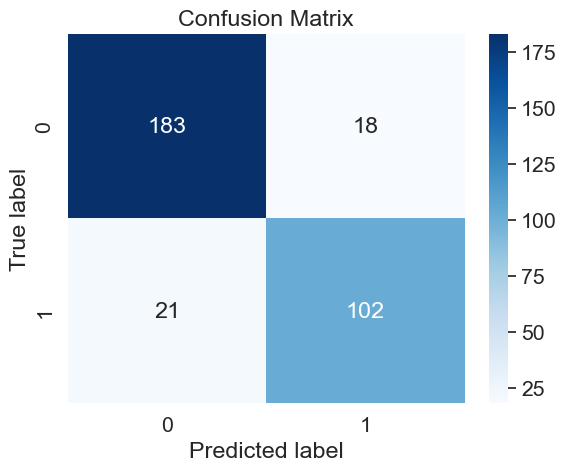

In [207]:
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
sns.set_theme(font_scale=1.4)
sns.heatmap(confusion_matrix_test, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

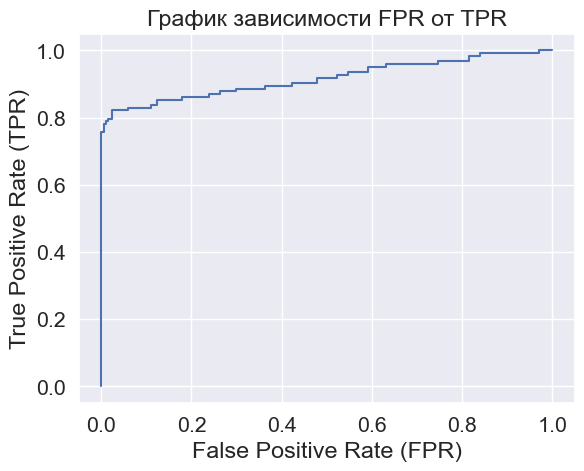

In [208]:
# рассчитаем значения FPR и TRP
fpr, tpr, threshold = roc_curve(y_test, preds[:,1], pos_label=1)

# построим график зависимости FPR от TPR
plt.plot(fpr, tpr)
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

### Вывод по результатам использования пайплайнов

Было выполнено: 
- создали тренировочную и тестовую выборки используя стратификацию;
- выполнили сэмплирование данных с использованием RandomOverSampler;
- разделили признаки на группы: 
	- для кодирования с использованием OneHotEncoder;
	- кодирования с использованием OrdinalEncoder;
	- масштабирования;
- создали пайплайн;
- использовали RandomizedSearchCV для подбора наилучших параметров модели.

Наилучшие показатели были получены для модели логистической регрессии.

В качестве основной метрики для оценки модели была выбрана метрика ROC AUC.

Для решения поставленной бизнес-задачи необходимо верно предсказывать значения, когда покупательская способность снизилась (в таблице указано как 0). Т.е. нас интересует метрика FPR и ROC AUC, соответственно. 

Метрика F1 интересует с точки зрения точности с учетом дисбаланса классов. 

Метрика Accuracy выбрана как наиболее общая. 

Значение метрики ROC-AUC на кросс валидационной выборке равно 0.9. 

Значение метрики ROC-AUC на тестовой выборке равно 0.92. 

## Анализ важности признаков

### График важности признаков по величине коэффициентов

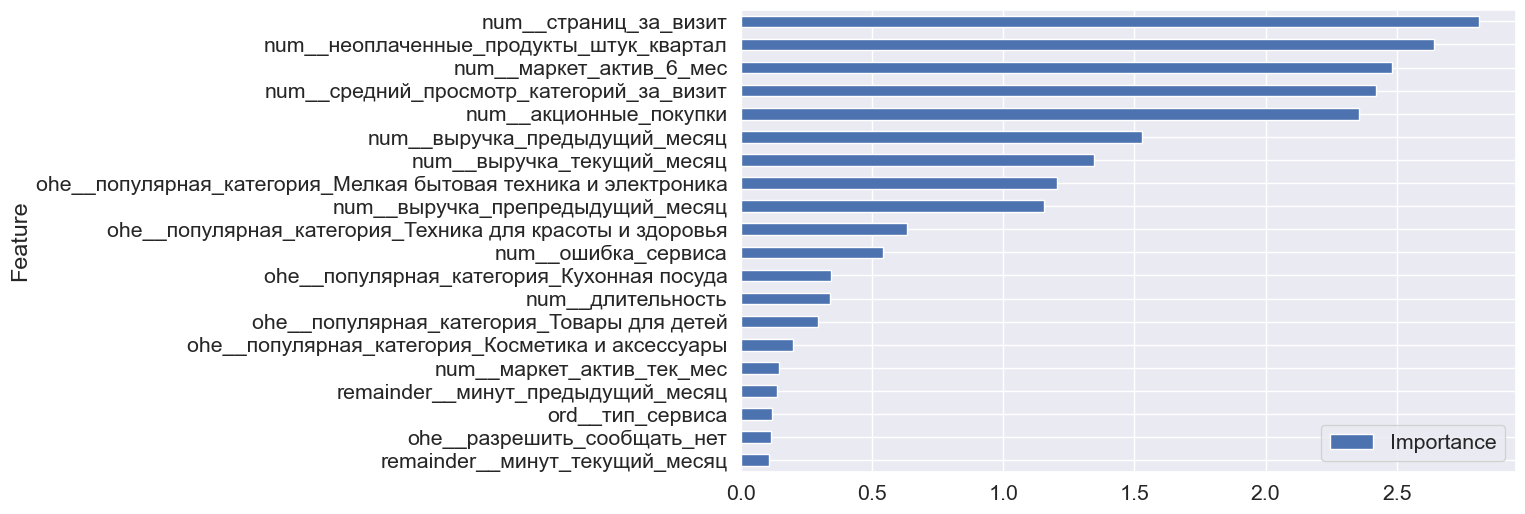

In [209]:
# строим график важности признаков по величине коэффициентов

coefficients = model._final_estimator.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_test_p.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

<!-- Наиболее важные признаки для модели:
- категория Мелкая бытовая техника и электроника;
- категория Техника для красоты и здоровья;
- акционные покупки;
- страниц за визит;
- минуты.

Наименее важные признаки: 
- данные признаков препредыдущий, предыдущий,текущий месяц;
- выручка. -->

Наиболее важные признаки для модели:
- страниц_за_визит;
- неоплаченные_продукты_штук_квартал;
- маркет_актив_6_мес;
- средний_просмотр_категорий_за_визит;
- акционные_покупки.

Наименее важные признаки: 
- тип_сервиса;
- разрешит_сообщать;
- минут_текущий_месяц.

### Проверка permutation importance

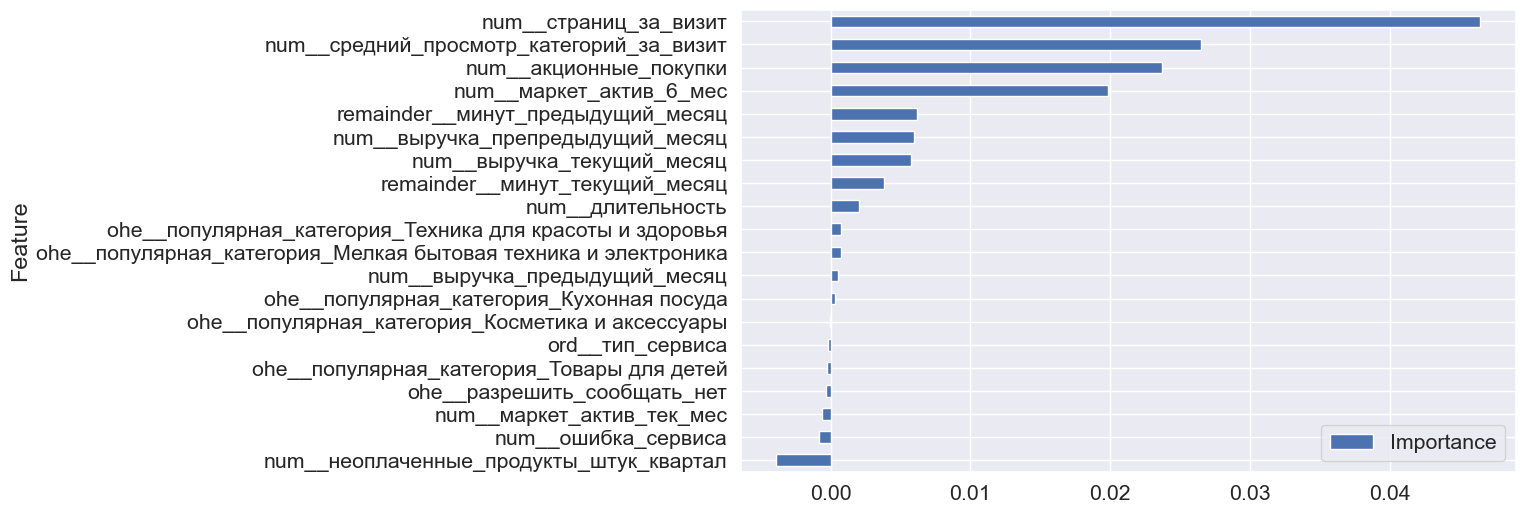

In [210]:
result = permutation_importance(model._final_estimator, X_test_p.values, y_test, scoring='roc_auc')

feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

<!-- Перемешивание значений выявило следующие важные признаки:
- страниц за визит;
- просмотр категорий за визит;
- акционные покупки;
- маркет_актив_6_мес;
- неоплаченные продукты_штук_квартал.

Наименее выжные признаки:
- разрешить сообщать;
- выручка;
- маркет_актив_тек_мес_кат;
- данные признаков препредыдущий, предыдущий,текущий месяц.  -->

Перемешивание значений выявило следующие важные признаки:
- страниц_за_визит;
- акционные_покупки;
- средний_просмотр_категорий_за_визит;
- маркет_актив_6_мес;
- минут_предыдущий_месяц.

Наименее выжные признаки:
- неоплаченные_продукты_штук_квартал;
- ошибка_сервиса;
- маркет_актив_тек_мес.

Многие признаки совпали, но появились и другие. 

### График shap.plots.beeswarm

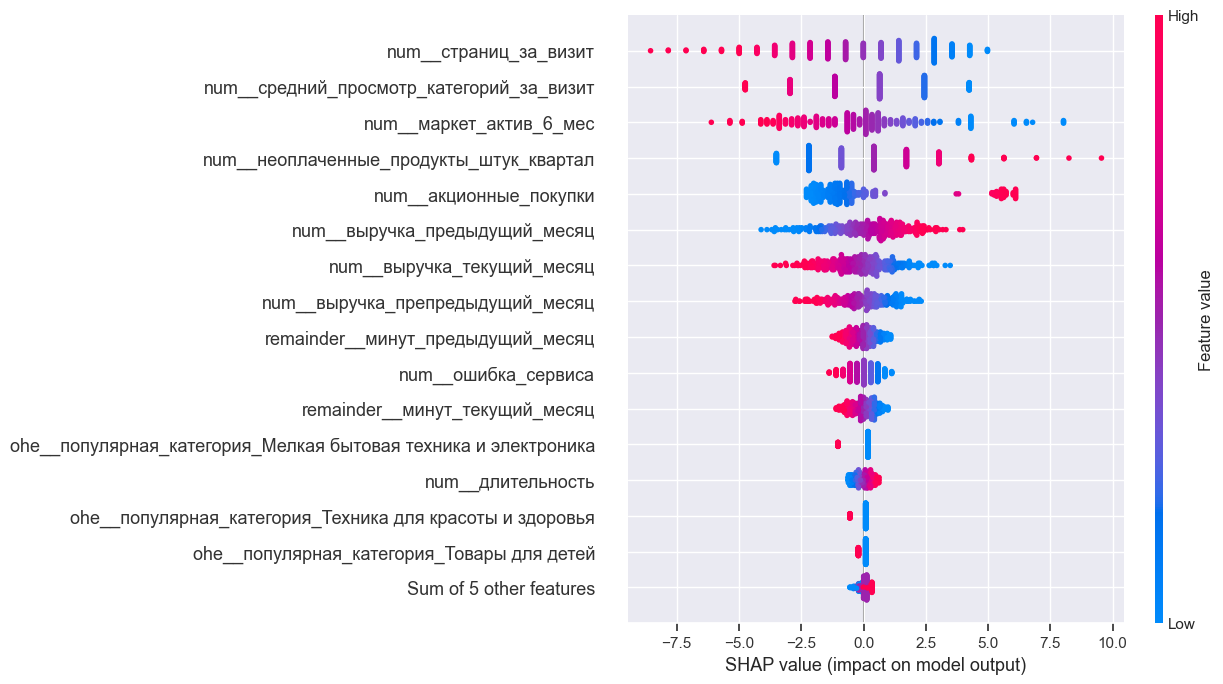

In [211]:
explainer = shap.LinearExplainer(model._final_estimator, X_test_p)
shap_values = explainer(X_test_p)

shap.plots.beeswarm(shap_values, max_display=16)

<!-- Чем больше значение признаков ниже, тем выше вероятность принадлежности к классу 1:
- маркет_актив_6_месяц;
- страниц_за_визит;
- категория Мелкая бытовая техника и электроника;
- категория Техника для красоты и здоровья. 

Чем больше значение признаков ниже, тем выше вероятность принадлежности к классу 0:
- неоплаченные_продукты_штук_квартал;
- акционные покупки_кат.  -->

Чем больше значение признаков ниже, тем выше вероятность того, что покупательская активность снизится:
- неоплаченные_продукты_штук_квартал;
- акционные_покупки;
- выручка_предыдущий_месяц.

Чем больше значение признаков ниже, тем выше вероятность того, что покупательская активность останется на прежнем уровне:
- маркет_актив_6_месяц;
- страниц_за_визит;
- средний_просмотр_категорий_за_визит.

### График shap.plots.waterfall

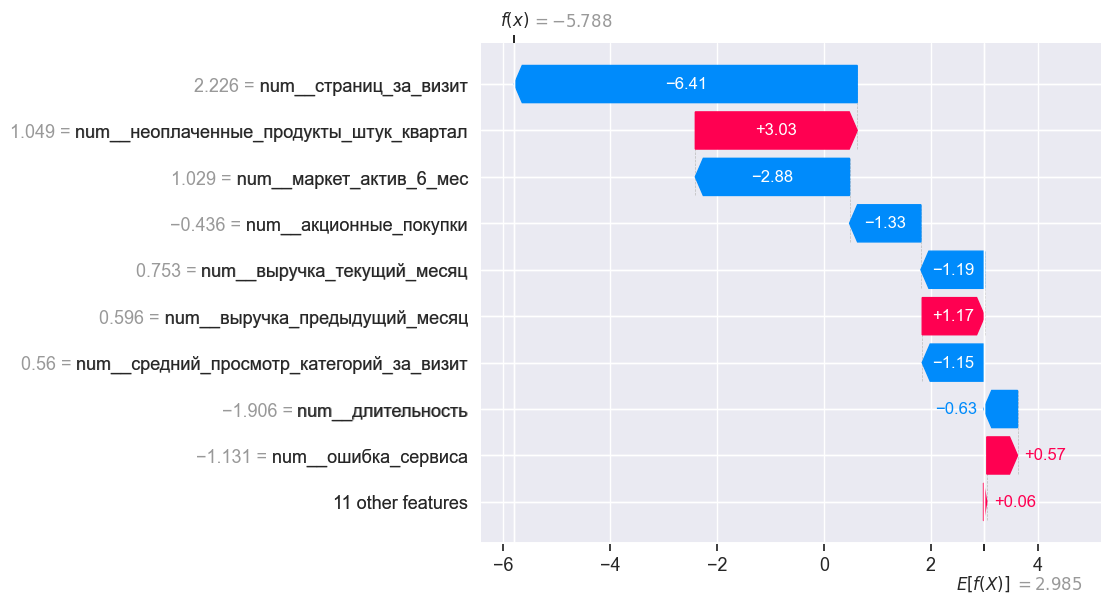

In [212]:
shap.plots.waterfall(shap_values[11]) 

<!-- На примере 11-го наблюдения в датасете можно увидеть, что наибольшее влияние имеет признак средний_просмотр_категорий_за_визит, который "перетягивает" предсказание в сторону класса 1.  -->

На примере 11-го наблюдения в датасете можно увидеть, что наибольшее влияние имеет признак страниц_за_визит, который "перетягивает" предсказание в сторону класса 0 (покупательская активность останется на прежнем уровне).

### График shap.plots.bar

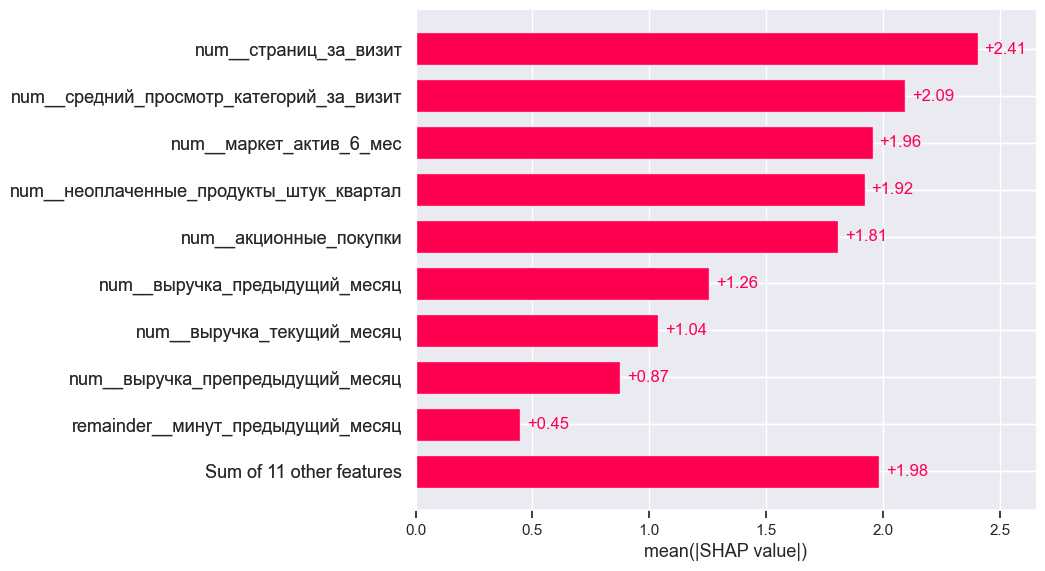

In [213]:
shap.plots.bar(shap_values) 

Для оценки общего вклада признаков в прогнозы модели использовали столбчатую диаграмму. 

Наибольшее влияние имеют признаки:
- страниц за визит;
- средний_просмотр_категорий_за_визит;
- маркет_актив_6_мес. 

<!-- - акционные покупки кат; -->

### Выводы по результатам анализа важности признаков

Можно с уверенностью сказать, что признаки акционные_покупки и страниц_за_визит в большей степени влияют на результаты модели. 

Данные признаков препредыдущий, предыдущий, текущий месяц и выручки влияют в меньшей степени. 

Таким образом при принятии бизнес-решений необходимо обращать внимание на то, какой процент акционных покупок у клиента (чем больше таких покупок, тем выше шанс снижения покупательской активности). Может быть это связано с прекращением акций? Или если акции теряют актуальность для конкретного пользователя? 

На покупательскую активность также влияют маркетинговые мероприятия. 

## Сегментация покупателей

### Создание выборки

In [214]:
# добавим в таблицу результаты модели и объединим с money
data = X_test.copy()

data[['y_proba_0', 'y_proba_1']] = preds
data['y_pred'] = y_test_pred

data = data.merge(money, on='id', how='inner')

data = data.set_index('id')
data.head()

выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
216161                    3973.0                       4912.0   
215654                    3548.0                       4656.0   
216307                    5444.0                       4565.0   
215501                    6604.0                       4993.0   
215934                    5090.0                       4451.0   

        выручка_текущий_месяц тип_сервиса разрешить_сообщать  \
id                                                             
216161                 3289.2    стандарт                 да   
215654                 4170.7     премиум                нет   
216307                 6335.8     премиум                 да   
215501                 6758.7     премиум                 да   
215934                 5773.8    стандарт                нет   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
216161                 4.1                     4           606   
215654                 1.4                     4           684   
216307                 3.3                     4           488   
215501                 3.5                     3          1057   
215934                 5.5                     4           147   

        акционные_покупки                  популярная_категория  \
id                                                                
216161               0.15        Техника для красоты и здоровья   
215654               0.94                      Товары для детей   
216307               0.13                     Домашний текстиль   
215501               0.35                     Домашний текстиль   
215934               0.99  Мелкая бытовая техника и электроника   

        средний_просмотр_категорий_за_визит  \
id                                            
216161                                    6   
215654                                    3   
216307                                    4   
215501                                    4   
215934                                    1   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
216161                                   1               4                12   
215654                                   6               1                 6   
216307                                   2               8                10   
215501                                   3               5                 6   
215934                                   2               3                 7   

        минут_предыдущий_месяц  минут_текущий_месяц  y_proba_0  y_proba_1  \
id                                                                          
216161                      16                   17   0.977397   0.022603   
215654                      11                    9   0.007742   0.992258   
216307                      20                   11   0.831752   0.168248   
215501                       9                    9   0.139514   0.860486   
215934                      15                   18   0.343924   0.656076   

        y_pred  прибыль  
id                       
216161       0     4.69  
215654       1     2.75  
216307       0     3.16  
215501       1     3.74  
215934       1     4.40

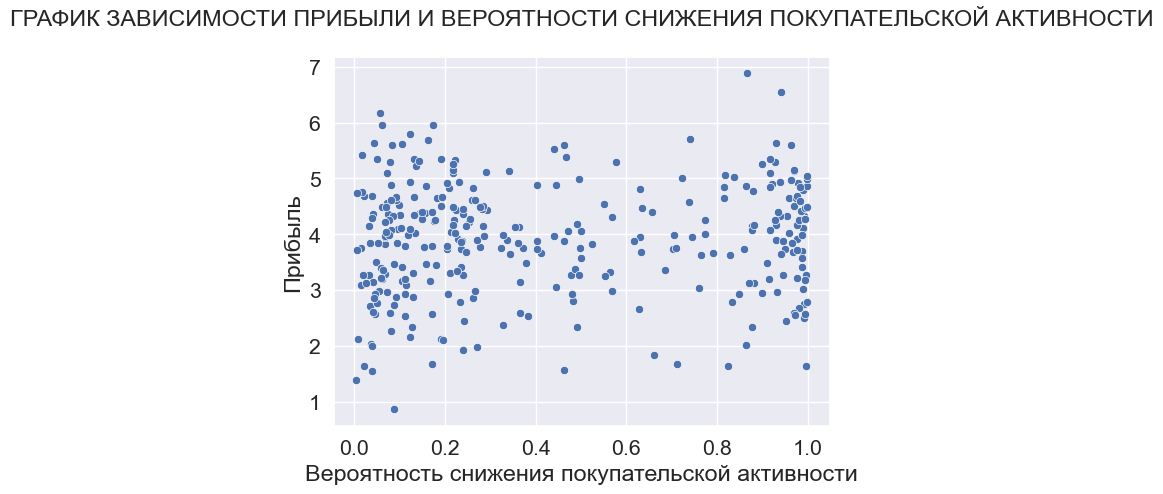

In [215]:
# построим график зависимости прибыли и вероятности снижения покупательской активности
sns.scatterplot(data=data, y=data['прибыль'], x=data['y_proba_1'])
plt.title("График зависимости прибыли и вероятности снижения покупательской активности\n".upper())
plt.xlabel('Вероятность снижения покупательской активности')
plt.ylabel('Прибыль')
plt.show()

In [216]:
# получим список покупателей, которые приносят больше всего прибыли
target_group = data.sort_values(by='прибыль', ascending=False)[:int(data.shape[0]/3)]
target_group.shape

(108, 20)

In [217]:
target_group.head()

выручка_предыдущий_месяц  выручка_препредыдущий_месяц  \
id                                                              
215563                    6036.5                       4985.0   
215505                    3951.0                       4698.0   
215749                    5190.0                       4928.0   
215837                    4893.0                       5268.0   
216493                    5371.5                       4944.0   

        выручка_текущий_месяц тип_сервиса разрешить_сообщать  \
id                                                             
215563                 6114.5     премиум                 да   
215505                 3982.2    стандарт                 да   
215749                 5092.5     премиум                 да   
215837                 4698.0     премиум                 да   
216493                 5872.0    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215563                 3.9                     5           956   
215505                 4.4                     4           254   
215749                 5.8                     5           624   
215837                 4.9                     3           888   
216493                 5.3                     4           129   

        акционные_покупки            популярная_категория  \
id                                                          
215563               0.35          Косметика и аксессуары   
215505               0.31                Товары для детей   
215749               0.30  Техника для красоты и здоровья   
215837               0.14  Техника для красоты и здоровья   
216493               0.21               Домашний текстиль   

        средний_просмотр_категорий_за_визит  \
id                                            
215563                                    2   
215505                                    2   
215749                                    4   
215837                                    3   
216493                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215563                                   2               6                 7   
215505                                   3               5                 3   
215749                                   3               6                14   
215837                                   1               6                 9   
216493                                   5               2                17   

        минут_предыдущий_месяц  минут_текущий_месяц  y_proba_0  y_proba_1  \
id                                                                          
215563                      10                    9   0.133009   0.866991   
215505                       7                    7   0.058309   0.941691   
215749                      14                   17   0.943579   0.056421   
215837                      15                   18   0.938139   0.061861   
216493                      16                    9   0.826069   0.173931   

        y_pred  прибыль  
id                       
215563       1     6.88  
215505       1     6.55  
215749       0     6.17  
215837       0     5.95  
216493       0     5.95

In [218]:
# разобьем на две группы
target_group_1 = target_group[target_group['y_pred']==1]
target_group_0 = target_group[target_group['y_pred']==0]

# сравним размер выборок
print(f'Покупательская активность снизится: {target_group_1.shape[0]}')
print(f'Покупательская активность останется на прежнем уровне: {target_group_0.shape[0]}')

Покупательская активность снизится: 43
Покупательская активность останется на прежнем уровне: 65


<!-- Выберем сегмент, для которого с большей долей вероятности будет верно предсказано значение покупательской активности, а также выберем тех клиентов, которые приносят среднюю прибыль.

Клиентов, которые приносят среднее количество прибыли, по количеству больше, поэтому совокупная прибыль выше. Возможно, они являются целевой аудиторией и их не стоит терять.  -->

Выберем сегмент покупателей, которые приносят больше всего прибыли. Разделим его на две группы и сравним признаки. 

### Анализ выбранной категории клиентов

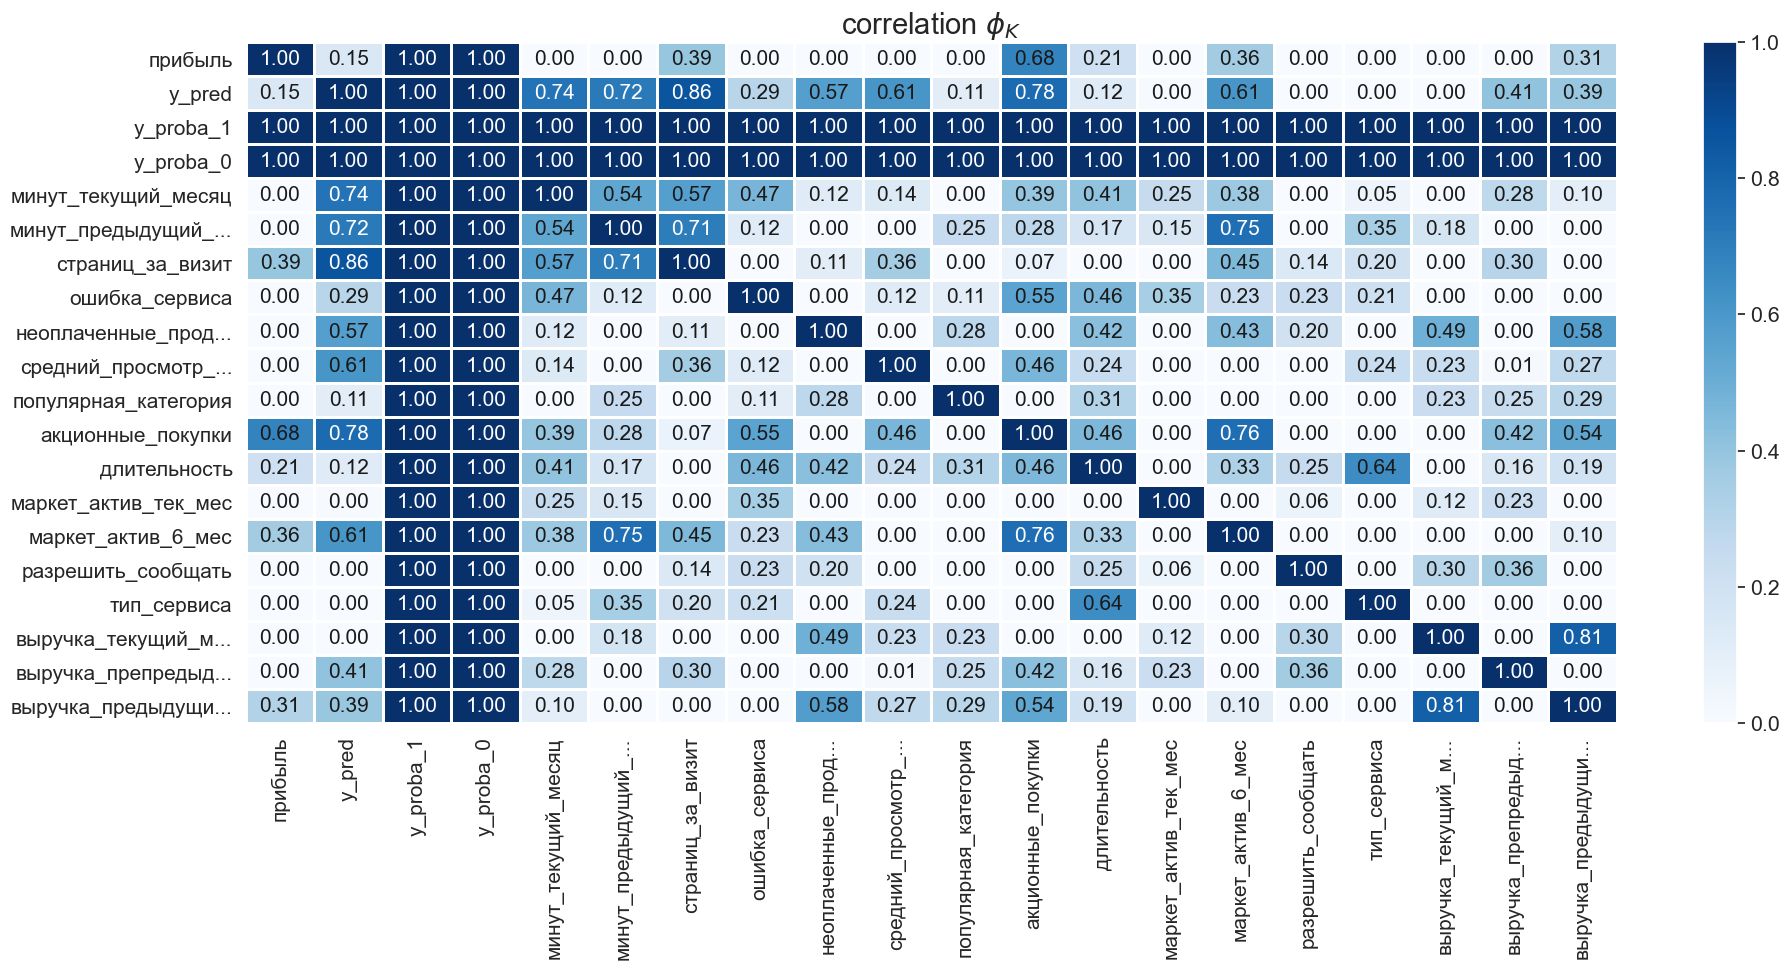

In [219]:
interval_cols = ['выручка_предыдущий_месяц', 
                 'выручка_препредыдущий_месяц',
                 'выручка_текущий_месяц',
                 'длительность', 
                 'маркет_актив_6_мес', 
                 'акционные_покупки,'
                 'средний_просмотр_категорий_за_визит', 
                 'неоплаченные_продукты_штук_квартал', 
                 'ошибка_сервиса', 
                 'страниц_за_визит', 
                 'минут_предыдущий_месяц',
                 'минут_текущий_месяц',
                 'прибыль']

phik_overview = phik_matrix(target_group, interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 10)
);

На матрице корреляций можно увидеть, что на прибыль выбранной категории клиентов, больше всего влияют признаки: 
- акционные покупки;
- страниц_за_визит;
- маркет_актив_6_мес.

#### Тип сервиса

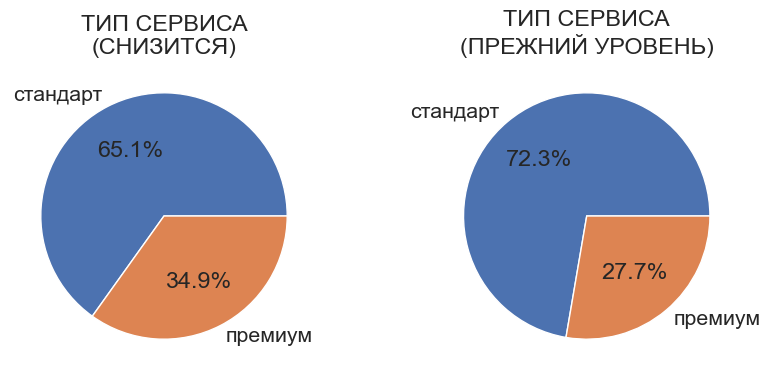

In [220]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
target_group_1.value_counts('тип_сервиса').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Тип сервиса\n(Снизится)'.upper())
plt.xlabel('')
plt.ylabel('');

plt.subplot(1, 2, 2)
target_group_0.value_counts('тип_сервиса').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Тип сервиса\n(Прежний уровень)'.upper())
plt.xlabel('')
plt.ylabel('');

Количество клиентов, чья покупательская способность останется на прежнем уровне, и использующих премиум сервис, немного ниже, чем у категории покупателей, чья покупательская способность снизится. 

#### Среднемесячное значение маркетинговых коммуникаций

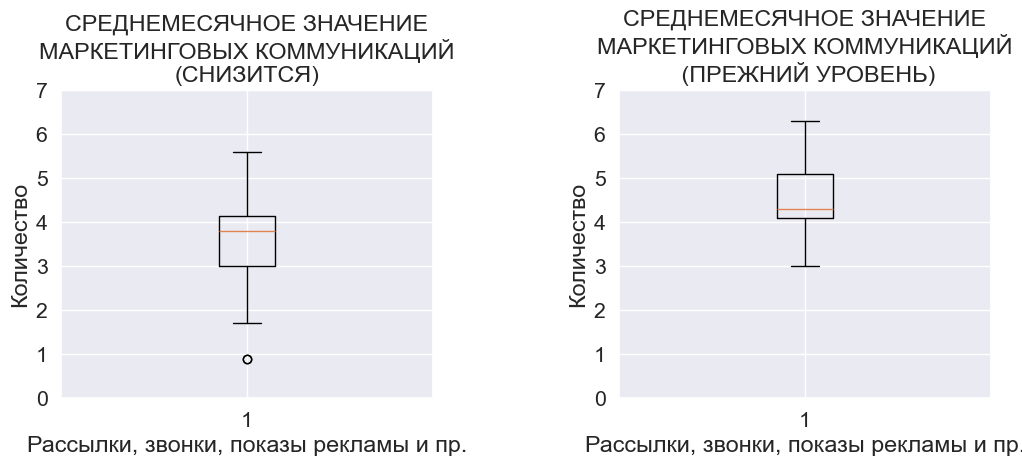

In [221]:
plt.figure(figsize=(12, 4))

# построим гистограмму
plt.subplot(1, 2, 1)
plt.boxplot(target_group_1['маркет_актив_6_мес'])
plt.title('Cреднемесячное значение\nмаркетинговых коммуникаций\n(снизится)'.upper())
plt.grid(visible=True)
plt.ylim(0, 7)
plt.xlabel('Рассылки, звонки, показы рекламы и пр.')
plt.ylabel('Количество');
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 2)
plt.boxplot(target_group_0['маркет_актив_6_мес'])
plt.title('Cреднемесячное значение\nмаркетинговых коммуникаций\n (прежний уровень)'.upper())
plt.grid(visible=True)
plt.ylim(0, 7)
plt.xlabel('Рассылки, звонки, показы рекламы и пр.')
plt.ylabel('Количество');

Медианное количество маркетинговых коммуникаций с клиентами с прежним уровнем покупательской активности выше, чем с покупателями, чья активность снизится.

#### Среднемесячная доля покупок по акции

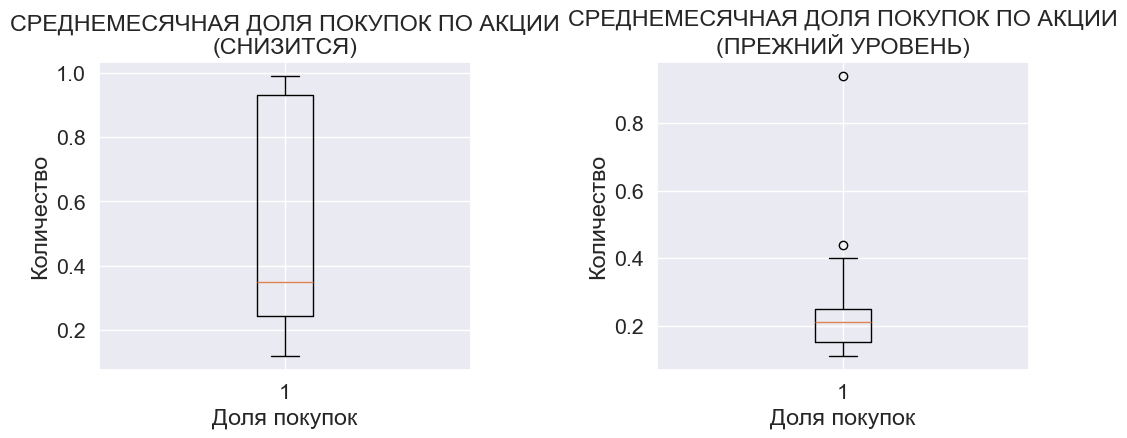

In [222]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.boxplot(target_group_1['акционные_покупки'])
plt.title('Среднемесячная доля покупок по акции\n(снизится)'.upper())
plt.grid(visible=True)
plt.xlabel('Доля покупок')
plt.ylabel('Количество')
plt.subplots_adjust(wspace=0.5);

plt.subplot(1, 2, 2)
plt.boxplot(target_group_0['акционные_покупки'])
plt.title('Среднемесячная доля покупок по акции\n(прежний уровень)'.upper())
plt.grid(visible=True)
plt.xlabel('Доля покупок')
plt.ylabel('Количество');

Среднемесячная доля покупок по акции у клиентов с прежним уровнем активности меньше, чем у покупателей, чья активность снизится. 

#### Количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца

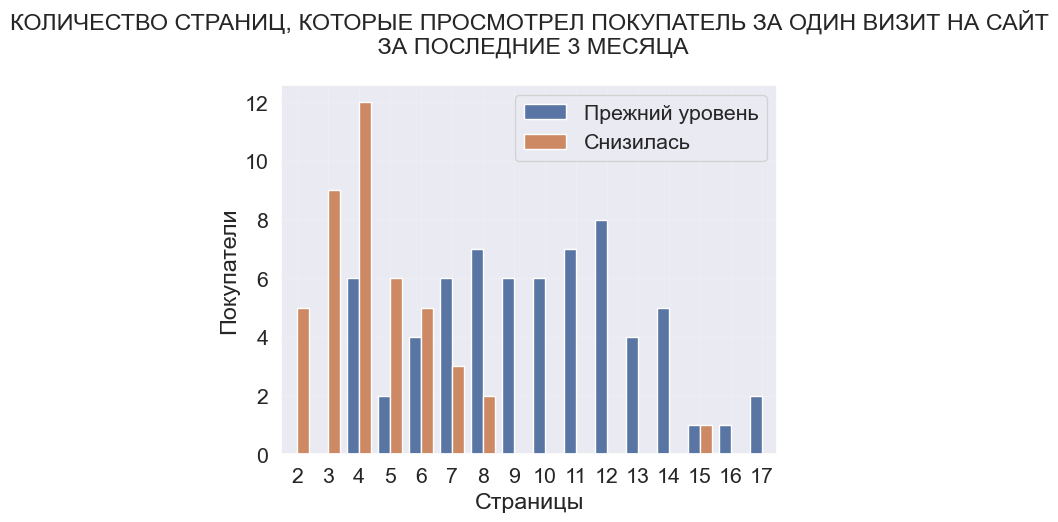

In [223]:
sns.countplot(data=target_group, x=target_group['страниц_за_визит'], hue='y_pred')
plt.title('Количество страниц, которые просмотрел покупатель за один визит на сайт\n за последние 3 месяца\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Страницы')
plt.ylabel('Покупатели')
plt.legend(labels=['Прежний уровень', 'Снизилась']);

Количество страниц, которые просмотрел покупатель с прежним уровнем покупательской активности за один визит на сайт за последние 3 месяца выше, чем у клиентов, чья покупательская активность снизится.

#### Популярные категории

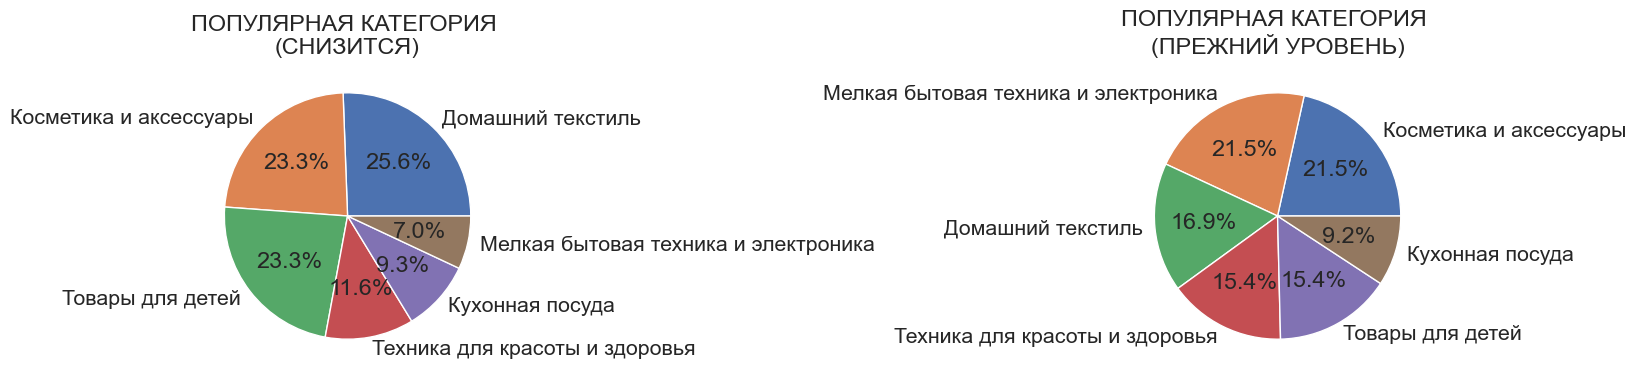

In [224]:
# посмотрим на популярные категории среди выбранной категории покупателей
plt.figure(figsize=(20,4))

plt.subplot(1, 2, 1)
target_group_1.value_counts('популярная_категория').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Популярная категория \n(Снизится)'.upper())
plt.xlabel('')
plt.ylabel('')
plt.subplots_adjust(wspace=0.5);

plt.subplot(1, 2, 2)
target_group_0.value_counts('популярная_категория').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Популярная категория \n(Прежний уровень)'.upper())
plt.xlabel('')
plt.ylabel('');

In [225]:
graph_1 = target_group_0.groupby('популярная_категория')[['выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']].sum()
graph_1

выручка_препредыдущий_месяц  \
популярная_категория                                                
Домашний текстиль                                         53673.0   
Косметика и аксессуары                                    68354.0   
Кухонная посуда                                           29380.0   
Мелкая бытовая техника и электроника                      68618.0   
Техника для красоты и здоровья                            48761.0   
Товары для детей                                          48050.0   

                                      выручка_предыдущий_месяц  \
популярная_категория                                             
Домашний текстиль                                      53610.0   
Косметика и аксессуары                                 71178.5   
Кухонная посуда                                        28681.5   
Мелкая бытовая техника и электроника                   70649.5   
Техника для красоты и здоровья                         43595.5   
Товары для детей                                       42438.0   

                                      выручка_текущий_месяц  
популярная_категория                                         
Домашний текстиль                                   54907.4  
Косметика и аксессуары                              75446.4  
Кухонная посуда                                     29466.7  
Мелкая бытовая техника и электроника                75209.9  
Техника для красоты и здоровья                      46806.5  
Товары для детей                                    47693.9

In [226]:
graph_2 = target_group_1.groupby('популярная_категория')[['выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']].sum()
graph_2

выручка_препредыдущий_месяц  \
популярная_категория                                                
Домашний текстиль                                         51527.0   
Косметика и аксессуары                                    46841.0   
Кухонная посуда                                           18418.0   
Мелкая бытовая техника и электроника                      13998.0   
Техника для красоты и здоровья                            23871.0   
Товары для детей                                          46936.0   

                                      выручка_предыдущий_месяц  \
популярная_категория                                             
Домашний текстиль                                      57889.0   
Косметика и аксессуары                                 50480.5   
Кухонная посуда                                        23389.0   
Мелкая бытовая техника и электроника                   16275.0   
Техника для красоты и здоровья                         22235.0   
Товары для детей                                       47070.0   

                                      выручка_текущий_месяц  
популярная_категория                                         
Домашний текстиль                                   62158.2  
Косметика и аксессуары                              52446.1  
Кухонная посуда                                     24721.5  
Мелкая бытовая техника и электроника                17754.4  
Техника для красоты и здоровья                      23694.9  
Товары для детей                                    49316.4

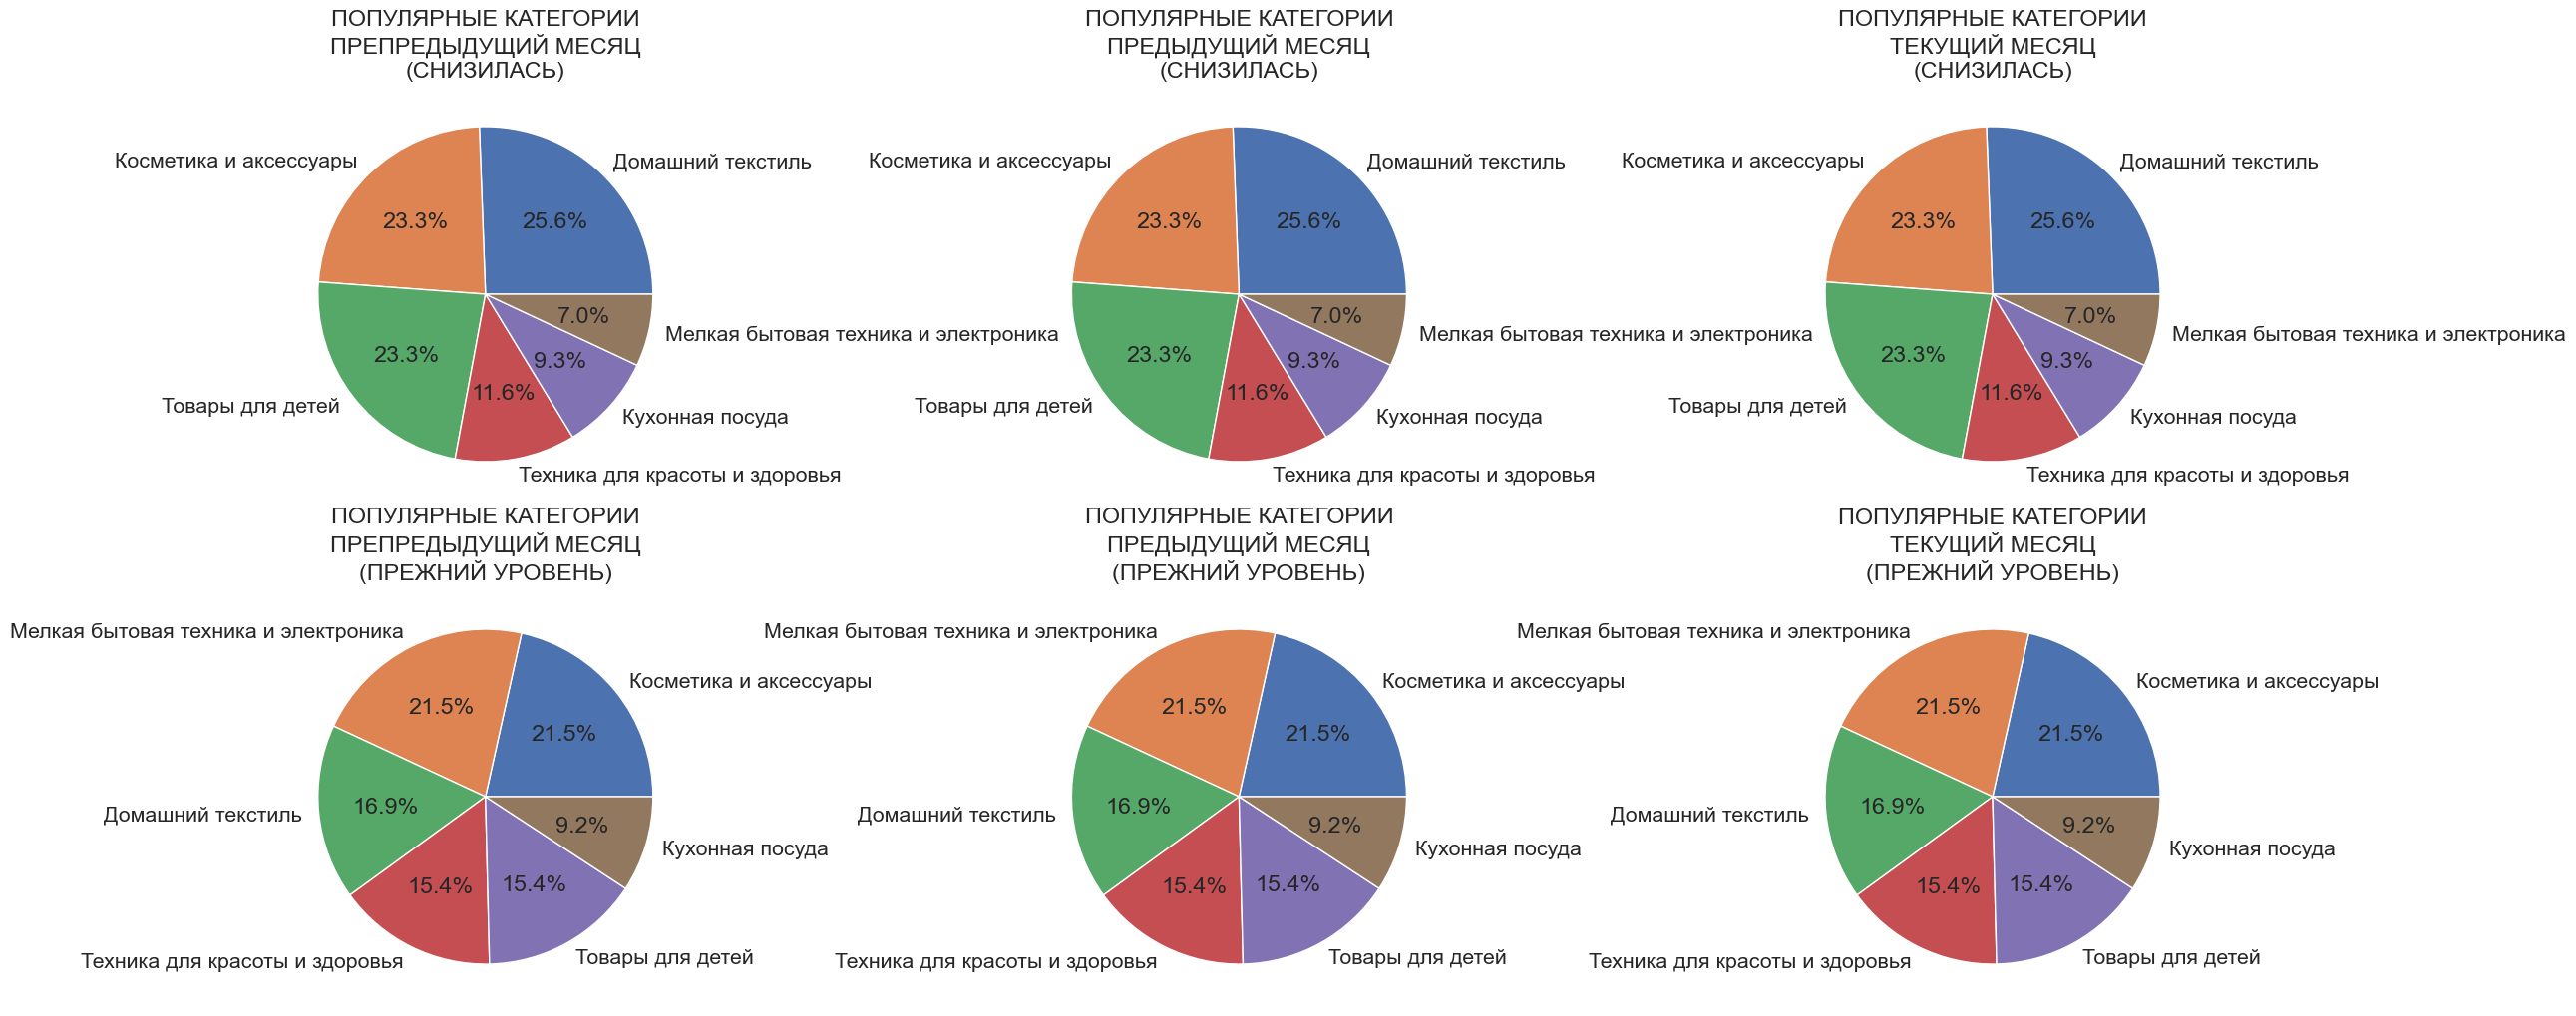

In [227]:
plt.figure(figsize=(26, 12))

plt.subplot(2, 3, 1)
target_group_1[['выручка_препредыдущий_месяц', 'популярная_категория']].value_counts('популярная_категория').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Популярные категории\nпрепредыдущий месяц\n(Снизилась)'.upper())
plt.xlabel('')
plt.ylabel('')
plt.subplots_adjust(wspace=0.5);

plt.subplot(2, 3, 2)
target_group_1[['выручка_препредыдущий_месяц', 'популярная_категория']].value_counts('популярная_категория').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Популярные категории\nпредыдущий месяц\n(Снизилась)'.upper())
plt.xlabel('')
plt.ylabel('')
plt.subplots_adjust(wspace=0.5);

plt.subplot(2, 3, 3)
target_group_1[['выручка_текущий_месяц', 'популярная_категория']].value_counts('популярная_категория').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Популярные категории\nтекущий месяц\n(Снизилась)'.upper())
plt.xlabel('')
plt.ylabel('')
plt.subplots_adjust(wspace=0.5);


plt.subplot(2, 3, 4)
target_group_0[['выручка_препредыдущий_месяц', 'популярная_категория']].value_counts('популярная_категория').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Популярные категории\nпрепредыдущий месяц\n(Прежний уровень)'.upper())
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 3, 5)
target_group_0[['выручка_препредыдущий_месяц', 'популярная_категория']].value_counts('популярная_категория').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Популярные категории\nпредыдущий месяц\n(Прежний уровень)'.upper())
plt.xlabel('')
plt.ylabel('');

plt.subplot(2, 3, 6)
target_group_0[['выручка_текущий_месяц', 'популярная_категория']].value_counts('популярная_категория').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Популярные категории\nтекущий месяц\n(Прежний уровень)'.upper())
plt.xlabel('')
plt.ylabel('');

При сравнее двух групп можно заметить, что:
- клиенты, у которых ожидается снижение покупательской активности, наиболее популярными являются группы товаров "Косметика и аксессуары", "Домашний текстиль", "Товары для детей";
- у второй категории клиентов - "Мелкая бытовая техника и электроника", которая наименее популярная для первой категории клиентов. 

### Предложения по увеличению покупательской активности
<!-- 
1. Увеличить маркетинговую активность в отношении данной категории клиентов (в среднем она ниже, чем для основной выборки покупателей). 
2. При разработке маркетинговой стратегии учитывать, что чем больше покупателей просматривает страниц перед покупкой, тем больше прибыль компании. 
3. Делать персонифицированные акции для покупателей с учетом следующих категории товаров: Косметика и аксессуары; Товары для детей. 
4. Проверять количество неоплаченных товаров и проводить анализ почему это происходит.  -->


1. Увеличить маркетинговую активность в отношении данной категории клиентов (в среднем она ниже, чем для основной выборки покупателей). 
2. При разработке маркетинговой стратегии учитывать, что:
- тип сервиса практически не влияет (или даже негативно влияет) на уровень покупательской активности. Возможно, стоит пересмотреть условия премиум сервиса;
- чем больше покупателей просматривает страниц перед покупкой, тем больше прибыль компании. 
3. Делать персонифицированные акции для покупателей с учетом следующих категории товаров: Косметика и аксессуары; Мелкая бытовая техника и электроника. 
4. Проверять количество неоплаченных товаров и проводить анализ почему это происходит. 
5. Контролировать поток покупок по акциям (возможно, стоит уменьшить их количество).

### Выводы по результатам сегментации покупателей

Был выбран сегмент, для которого с большей долей вероятности будет верно предсказано значение покупательской активности, а также выберем тех клиентов, которые приносят среднюю прибыль.

Возможно, они являются целевой аудиторией и их не стоит терять. 

Были сделаны предложения по увеличению покупательской активности, которые направлены на изменение маркетинговой стратегии и анализа покупательской активности клиентов.

## Общий вывод

1. Была поставлена задача: разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

2. Была выполнена предобработка данных:
- корректировка названий столбцов;
- корректировка значений для исключения неявных дубликатов.

Пропуски и полные дубликаты строк в данных отсутствовали. 

3. Был выполнен исследовательский анализ данных:

3.1. Были удалены выбросы в столбце "выручка".

3.2. Были удалены из выборки клиенты, чья покупательская активность составляла менее 3 месяцев подряд. 

4. Было выполнено объединение данных из таблиц market_money, market_file, market_time.

5. Был выполнен корреляционный анализ данных:
- выявлен высокий уровень корреляции между признаками "страниц_за_визит" и "покупательская_активность";
- выявлен высокий уровень корреляции между признаками "минут_предыдущий_месяц" и "покупательская_активность";
- выявлен умеренный уровень корреляции между признаками "Cредний_просмотр_категорий_за_визит" и "покупательская_активность";
- выявлен умеренный уровень корреляции между признаками "маркет_актив_6_мес" и "покупательская_активность". 

6. Был создан пайплайн:

6.1. Создали тренировочную и тестовую выборки используя стратификацию.

6.2. Использовали сэмплирование данных с помощью class_weights.

6.3. Разделили признаки на группы: 

- для кодирования с использованием OneHotEncoder;
- кодирования с использованием OrdinalEncoder;
- масштабирования.

6.4. Создали пайплайн. 

6.5. Использовали RandomizedSearchCV для подбора наилучших параметров модели.

Наилучшие показатели были получены для модели логистической регрессии (см. ниже).

В качестве основной метрики для оценки модели была выбрана метрика ROC AUC.

Значение метрики ROC-AUC на кросс валидационной выборке равно 0.9. 

7. Был выполнен анализ важности признаков:
- признаки акционные_покупки и страниц_за_визит в большей степени влияют на результаты модели;
- на покупательскую активность влияют неоплаченные продукты за квартал, акционные покупки.

8. Была выполнена сегментация покупателей:
Был выбран сегмент наиболее прибыльных покупателей.

Предложения по увеличению покупательской активности:

1. Увеличить маркетинговую активность в отношении данной категории клиентов (в среднем она ниже, чем для основной выборки покупателей). 
2. При разработке маркетинговой стратегии учитывать, что:
- тип сервиса практически не влияет (или даже негативно влияет) на уровень покупательской активности. Возможно, стоит пересмотреть условия премиум сервиса;
- чем больше покупателей просматривает страниц перед покупкой, тем больше прибыль компании. 
3. Делать персонифицированные акции для покупателей с учетом следующих категории товаров: Косметика и аксессуары; Мелкая бытовая техника и электроника. 
4. Проверять количество неоплаченных товаров и проводить анализ почему это происходит. 
5. Контролировать поток покупок по акциям (возможно, стоит уменьшить их количество).

In [228]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(s...
                                                   'маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_категорий_за_визит',
                                                   'неоплаченные_продукты_штук_квартал',
                                                   'ошибка_сервиса',
                                                   'страниц_за_визит'])])),
                ('models',
                 LogisticRegression(C=9,
                                    class_weight={0: np.float64(0.8079800498753117),
                                                  1: np.float64(1.311740890688259)},
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])